# Análisis Exploratio de Datos

### Importación de Bibliotecas de trabajo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
from matplotlib.pyplot import imread
import codecs
from IPython.display import HTML
import boto3, os
s3 = boto3.resource('s3')
get_ipython().system(' aws s3 ls')

2020-11-11 08:58:12 aws-glue-scripts-377854358459-us-west-2
2020-11-11 08:58:14 aws-glue-temporary-377854358459-us-west-2
2020-11-11 08:30:46 imdb-movies
2020-11-11 08:40:37 imdb-scores
2020-12-05 16:30:49 imdbuser
2020-11-10 07:11:42 myresults-sql
2020-11-15 09:16:45 sagemaker-studio-q8mdpvbl9rs


### Importación de Datasets

In [2]:
# Importando dataset de peliculas
bucket='imdb-movies'
data_key = 'tmdb_5000_movies.csv'
data_location = 's3://imdb-movies/tmdb_5000_movies.csv'.format(bucket, data_key)

movies = pd.read_csv(data_location)

In [3]:
movies.shape

(4803, 20)

In [4]:
# Importando dataset de creditos
bucket='imdb-scores'
data_key = 'tmdb_5000_credits.csv'
data_location = 's3://imdb-scores/tmdb_5000_credits.csv'.format(bucket, data_key)

credits = pd.read_csv(data_location)

In [5]:
credits.shape

(4803, 4)

In [6]:
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [7]:
# Creando copia del original para trabajar en limpio
credit = credits.copy()

In [8]:
# Renombrando columna de movie_id a id para poder unir después
scores1 = credits.rename(columns={'movie_id':'id', 'title': 'title_credits'})
scores1.columns

Index(['id', 'title_credits', 'cast', 'crew'], dtype='object')

In [9]:
# Haciendo una copia del original para trabajar en limpio
movie = movies.copy()

In [10]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

### Conversión de columnas en formato Json a strings

In [11]:
# Cambiando la columna genres a string
movies['genres'] = movies['genres'].apply(json.loads)
for index,i in zip(movies.index,movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # la palabra clave 'name' contiene el string
    movies.loc[index,'genres'] = str(list1)

# Cambiando la columna keywords a string
movies['keywords'] = movies['keywords'].apply(json.loads)
for index,i in zip(movies.index,movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'keywords'] = str(list1)
    
# Cambiando la columna production_companies a string
movies['production_companies'] = movies['production_companies'].apply(json.loads)
for index,i in zip(movies.index,movies['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_companies'] = str(list1)

# Cambiando la columna spoken_languages a string
movies['spoken_languages'] = movies['spoken_languages'].apply(json.loads)
for index,i in zip(movies.index,movies['spoken_languages']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'spoken_languages'] = str(list1)

# Cambiando la columna production_countries a string
movies['production_countries'] = movies['production_countries'].apply(json.loads)
for index,i in zip(movies.index,movies['production_countries']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_countries'] = str(list1)
    
# Cambiando la columna cast a string
scores1['cast'] = scores1['cast'].apply(json.loads)
for index,i in zip(scores1.index,scores1['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    scores1.loc[index,'cast'] = str(list1)

# Cambiando la columna crew a string y cambiandole el nombre a 'Director' 
scores1['crew'] = scores1['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director': # en este caso solo se va a extraer al director que es el que nos interesa para el sistema de recomendación
            return i['name']
scores1['crew'] = scores1['crew'].apply(director)
scores1.rename(columns={'crew':'director'},inplace=True)

### Uniendo datasets

In [12]:
movies = movies.merge(scores1,on='id')

In [13]:
movies.shape

(4803, 23)

In [14]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'title_credits', 'cast', 'director'],
      dtype='object')

In [15]:
movies.iloc[22]

budget                                                          250000000
genres                                           ['Adventure', 'Fantasy']
homepage                                        http://www.thehobbit.com/
id                                                                  57158
keywords                ['elves', 'dwarves', 'orcs', 'hobbit', 'dragon...
original_language                                                      en
original_title                        The Hobbit: The Desolation of Smaug
overview                The Dwarves, Bilbo and Gandalf have successful...
popularity                                                        94.3706
production_companies    ['WingNut Films', 'New Line Cinema', 'Warner B...
production_countries          ['New Zealand', 'United States of America']
release_date                                                   2013-12-11
revenue                                                         958400000
runtime                               

Ambos datasets fueron unidos con éxito y ahora se puede usar solamente un dataset al que llamamos como 'movies'.

### Encontrando valores nulos

In [16]:
movies.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
title_credits              0
cast                       0
director                  30
dtype: int64

### Analisis valores nulos: 

1. Para este caso se tiene que 'homepage' es la columna que más valores nulos posee y lo que indica es la dirección de la página web, para nuestro análisis no es relevante, ya que no se va a trabajar con esta columna ya que para todas las películas va a ser diferente y sería como el 'id', lo mismo pasa con la columna 'tagline' ya que es como un slogan y no se ve utilidad práctica en dejarla, así que no se trabajará con estas dos. 
2. 'Overview' esta solo tiene 3 valores nulos lo que representa un $\frac{3}{4803} = 0.00006$% del total, por lo que no es significativo y como es menos de un 5% se puede proceder a borrar los valores nulos. 
3. 'release_date' solo contiene un valor nulo, y al igual que 'overview' se puede proceder a eliminar el valor nulo. 
4. 'runtime' tiene dos valores nulos y al igual que con las otras variables expuestas se puede proceder a eliminarla, ya que no es representativa. 
5. 'Director' contiene 30 valores nulos y se refiere al nombre del director de la película y como son solo 30 valores que no aparecen se puede proceder a eliminarlos, ya que no son significativos. 

### Eliminando NaNs y quitando columnas innecesarias

In [17]:
movies=movies.dropna(subset=['overview'])
movies=movies.dropna(subset=['release_date'])
movies=movies.dropna(subset=['runtime'])
movies=movies.dropna(subset=['overview'])
movies=movies.dropna(subset=['director'])

In [18]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'title_credits', 'cast', 'director'],
      dtype='object')

In [19]:
movies = movies[['budget', 'genres', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'title', 'vote_average',
       'vote_count', 'title_credits', 'cast', 'director']]

In [20]:
movies.isnull().sum()

budget                  0
genres                  0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
title_credits           0
cast                    0
director                0
dtype: int64

In [21]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4770 entries, 0 to 4802
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4770 non-null   int64  
 1   genres                4770 non-null   object 
 2   id                    4770 non-null   int64  
 3   keywords              4770 non-null   object 
 4   original_language     4770 non-null   object 
 5   original_title        4770 non-null   object 
 6   overview              4770 non-null   object 
 7   popularity            4770 non-null   float64
 8   production_companies  4770 non-null   object 
 9   production_countries  4770 non-null   object 
 10  release_date          4770 non-null   object 
 11  revenue               4770 non-null   int64  
 12  runtime               4770 non-null   float64
 13  spoken_languages      4770 non-null   object 
 14  status                4770 non-null   object 
 15  title                

Se puede ver como ahora el dataset cambió y se tienen 4770 observaciones y ya no se cuentan con registros nulos.

### Inspeccionando el tipo de formato de la variable

In [22]:
movies.dtypes

budget                    int64
genres                   object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
title                    object
vote_average            float64
vote_count                int64
title_credits            object
cast                     object
director                 object
dtype: object

In [23]:
# Convirtiendo la variable "id" a objeto, ya que en realidad es una variable cualitativa
# Convirtiendo la variable "budget" y "revenue" a float, ya que en realidad son variables cuantitativas continuas
# Convirtiendo la variable 'release_date' a datetime, ya que no es un objeto. 

movies['id']= movies['id'].astype('object')
movies['revenue']= movies['revenue'].astype('float64')
movies['budget']= movies['budget'].astype('float64')
import datetime
movies['release_date'] = pd.to_datetime(movies['release_date'])

In [24]:
movies.dtypes

budget                         float64
genres                          object
id                              object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                        float64
runtime                        float64
spoken_languages                object
status                          object
title                           object
vote_average                   float64
vote_count                       int64
title_credits                   object
cast                            object
director                        object
dtype: object

### Análisis:

1. Se cuenta con 1 variable cuantitativas discretas. 
2. Hay 5 variables cuantitativas continuas. 
3. Hay 1 variable de tipo fecha. 
3. Hay 14 variables cualitativas.

### Análisis de las variables cualitativas

In [25]:
# Trabajando con la columna 'genres'

movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

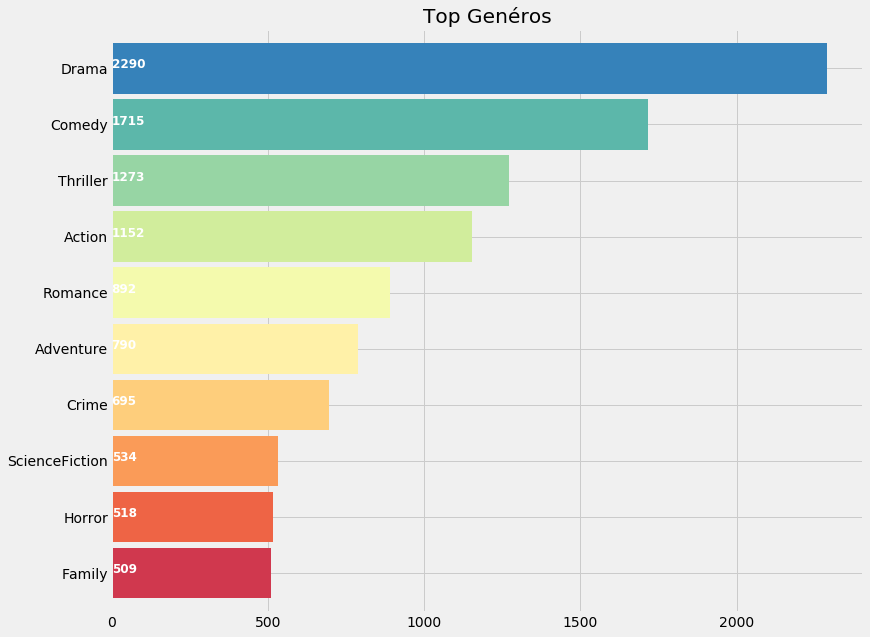

In [26]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('Spectral',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genéros')
plt.show()

Viendo el grafico se puede ver que el género más recurrente son las películas de drama (moda) seguido por las películas de Comedia y por las películas del género thriller. 

Es importante mencionar que los géneros se pueden repetir varias veces, porque cada película puede tener más de un género, de ahí que se obtenga un conteo mayor a 4770 del total de películas. 

In [27]:
# Trabajando con la columna 'cast'

movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['cast'] = movies['cast'].str.split(',')

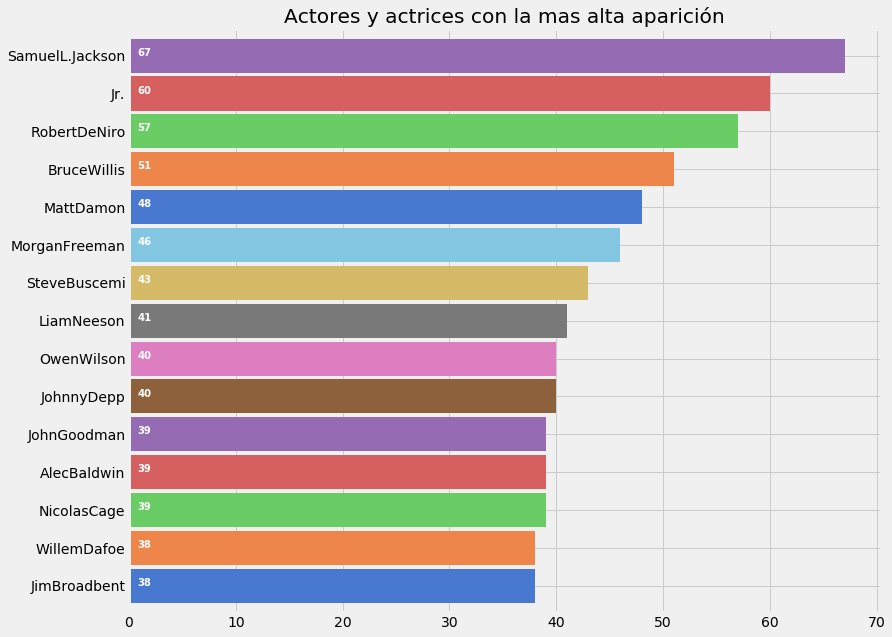

In [28]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actores y actrices con la mas alta aparición')
plt.show()

Con este gráfico se puede ver de primera entrada dos cosas:

1. Samuel Jackson es el actor que más aparece en el dataset (moda), seguido de JR., y en tercer lugar Robert de Niro. 
2. En las películas no encabeza la lista alguna mujer, es decir las mujeres son las que menos aparición tienen. 

In [29]:
# Trabajando con la columna 'production_companies'

movies['production_companies'] = movies['production_companies'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['production_companies'] = movies['production_companies'].str.split(',')

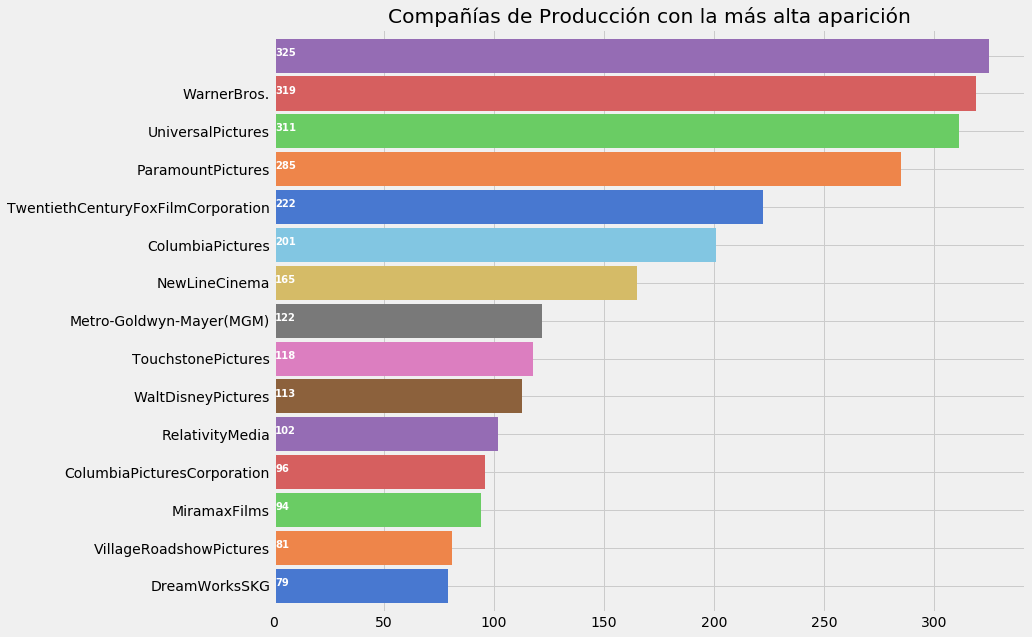

In [30]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['production_companies']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Compañías de Producción con la más alta aparición')
plt.show()

Se puede ver que la lista esta encabezada por compañías que o bien no son muy conocidas y por eso no se tiene el nombre o que no se recolectaron durante la conformación del dataset. 

Dejando esto de lado se puede ver como la productora que más apariciones tiene es Warner Bros, seguida de Universal Pictures, y Paramount pictures. 

In [31]:
# Trabajando con la columna 'production_countries'

movies['production_countries'] = movies['production_countries'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['production_countries'] = movies['production_countries'].str.split(',')

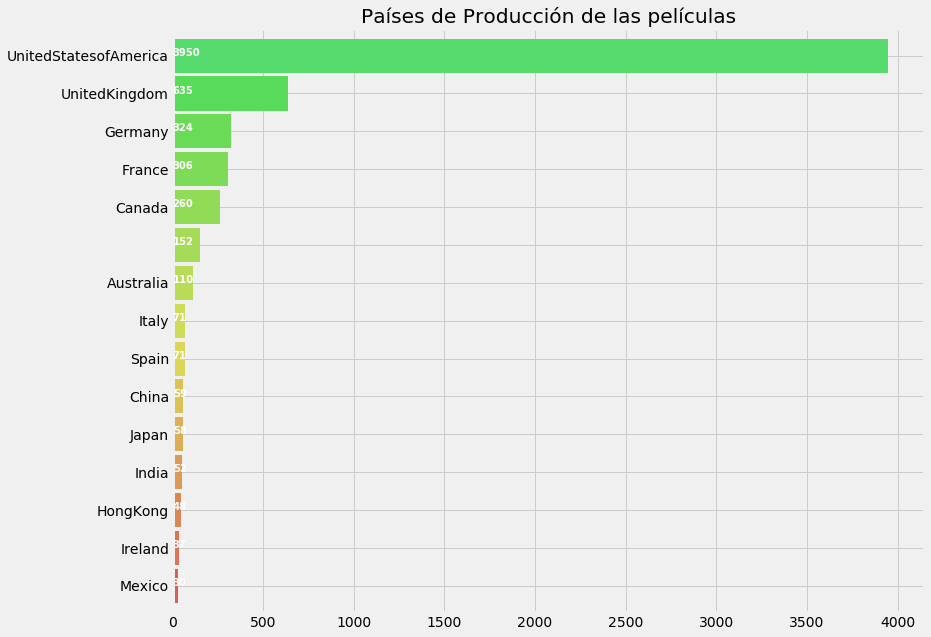

In [32]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['production_countries']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Países de Producción de las películas')
plt.show()

Con este gráfico se puede ver como la mayoría de películas que aparecen en este dataset son efectivamente de Estados Unidos (moda) en segundo lugar fueron producidas en el Reino unido y en tercer lugar en Alemania, de ahí que el idioma inglés aparezca tantas veces, cabe destacar que España y México que son de habla hispana aparecen casi de último. 

In [33]:
# Trabajando con la columna de 'original language'

pd.value_counts(movies['original_language'])

en    4474
fr      70
es      32
zh      27
de      26
hi      19
ja      16
it      13
cn      12
ru      11
ko      11
pt       9
da       7
sv       5
fa       4
nl       4
he       3
th       3
ar       2
id       2
ro       2
cs       2
ta       2
vi       1
ky       1
te       1
no       1
nb       1
ps       1
xx       1
sl       1
pl       1
af       1
hu       1
tr       1
is       1
el       1
Name: original_language, dtype: int64

Se puede observar que la mayoría de películas el idioma original es inglés, por lo que, o son películas hollywoodenses o fueron hechas en países de habla inglesa, seguidas por las películas de idioma francés y en tercer lugar las que son en español. 

In [34]:
# Trabajando con la columna 'spoken_languages'

movies['spoken_languages'] = movies['spoken_languages'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['spoken_languages'] = movies['spoken_languages'].str.split(',')

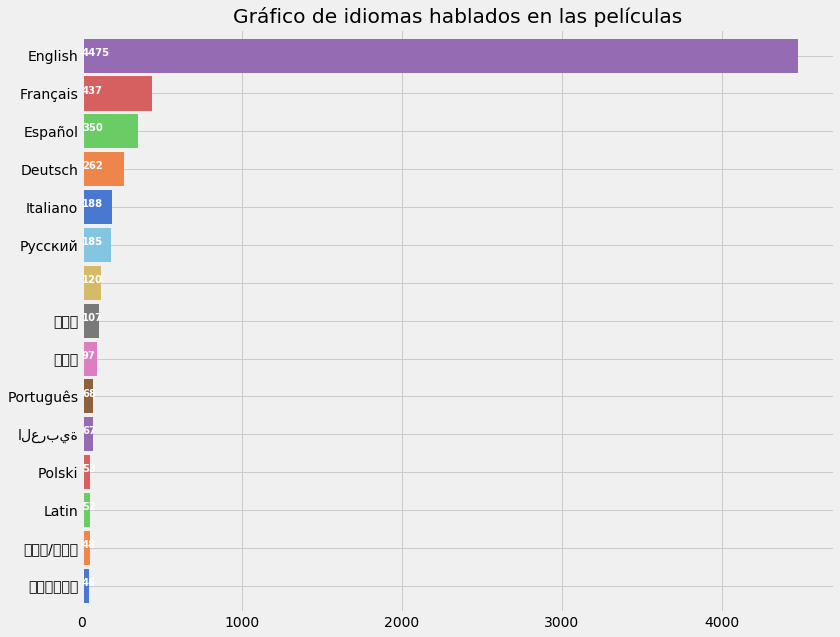

In [35]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['spoken_languages']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Gráfico de idiomas hablados en las películas')
plt.show()

Con este otro gráfico podemos ver que aunque el inglés sigue siendo el idioma más hablado, durante las películas aparecen otros idiomas, aunque se vuelven a repetir inglés, francés y español consecutivamente. 

In [36]:
# Trabajando con la columna de 'status'

pd.value_counts(movies['status'])

Released           4764
Post Production       3
Rumored               3
Name: status, dtype: int64

Con esta última variable se puede ver que prácticamente todas las películas en este dataset ya fueron lanzadas y solo hay tres rumoreadas y otras tres en post produccón. 

In [37]:
# Trabajando con la columna 'director'

def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)

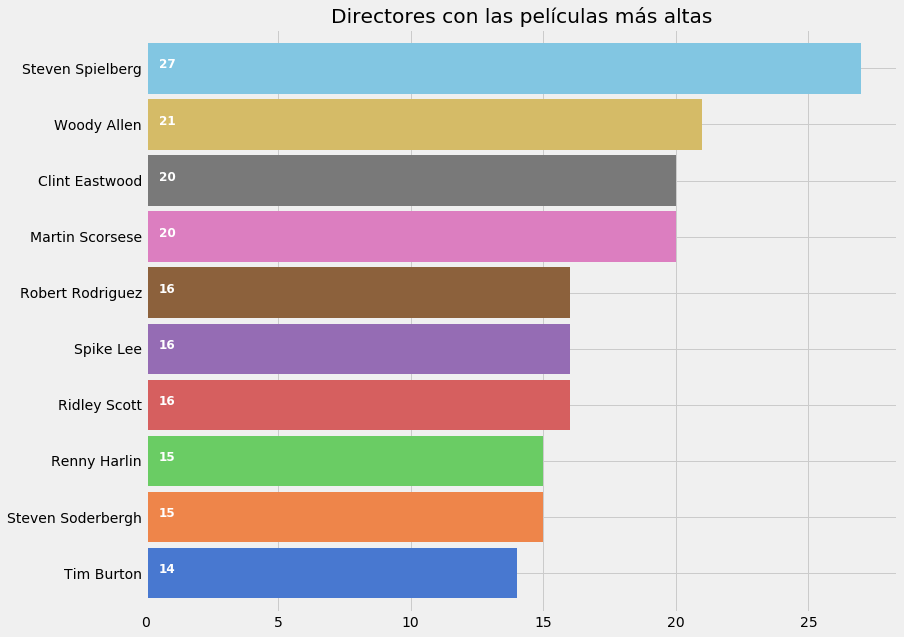

In [38]:
plt.subplots(figsize=(12,10))
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directores con las películas más altas')
plt.show()

Gracias a este gráfico se puede ver como los directores con las películas más altas en puntuación son respectivamente: Steven Spielberg, Woody Allen, y Martin Scorsese, los tres de Estados Unidos. 

In [39]:
# Trabajando con la columna 'keywords'

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

In [40]:
movies['keywords']=movies['keywords'].apply(str)

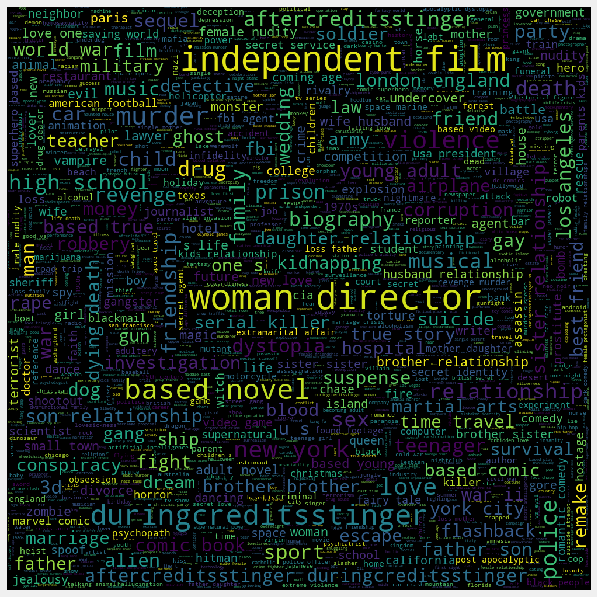

In [41]:
plt.subplots(figsize=(20,20))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

**Análisis**

Con el wordcloud previo se puede ver fácilmente cuáles son las palabras, bigramas o trigamas que más se repiten a nivel de las keywords. 

En este caso se puede ver como *film*, *independent*, *duringcreditsstinger*, *murder*, *woman director*, *violence*, *new york*, *young adult*, *aftercreditsstinger*, *relationship*, etc., son las que más se repiten y por eso se ven mucho más grandes a nivel de la nube de palabras, por lo que se puede decir que son las que en una parte muy grande las películas se citan en el apartado de palabras clave. 

### Análisis de Variables cualitativas restantes

Con las siguientes variables: *id*, *original_title*, *overview*, *title*, *title_credits* se ha decidido no hacer un análisis ya que por un lado *id* corresponde a un número de identificación de cada película, es un número único, por lo que, no arroja ningún tipo de información valiosa, salvo ubicar la película dentro del dataset. 

Con *original_title*, *title*, *title_credits*, en realidad aunque son tres variables corresponden a la misma. Por un lado el *original_title* es el título original de la película, que en este caso puede ser en el idioma de producción, *title* es el título en inglés y *title_credits* es el mismo título que ya se mencionó en inglés; pero en este caso el *title_credist* corresponde al título que venía en el dataset de créditos (scores). Para todos estos casos corresponden a nombres únicos por lo que, al igual que el *id*, no va a arrojar información importante, salvo utilizarlo para recomendar la película en cuestión.

Finalmente *overview* corresponde a una leve sinopsis de lo que trata la película, para nuestro caso todas las películas van a tener descripciones bastante diferentes, por lo que, no se ve necesario hacer un análisis de esta variable, ya que en su lugar se hizo el de 'keywords'. 

### Análisis de variable en formato fecha

Con esta variable por sí sola no se puede sacar mucha información, ya que no nos aporta mucho saber las fechas en que han salido las películas a lo largo del tiempo porque son estáticas, es por ello que el verdadero análisis se podrá hacer mediante feature engineering tanto obteniendo los años así como los meses y días; para saber la distribución de las películas a lo largo de los años.

In [42]:
# Obteniendo año y mes de las películas y creando nueva columna
movies['year'] = movies['release_date'].dt.year
movies['month'] = movies['release_date'].dt.month
movies['day'] = movies['release_date'].dt.day

In [43]:
movies['decade'] = (movies['year']//10)*10
movies.head(1) # columna 'decade' creada con éxito, al igual que la columna 'year', 'month' y 'day'

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,title,vote_average,vote_count,title_credits,cast,director,year,month,day,decade
0,237000000.0,"[Action, Adventure, Fantasy, ScienceFiction]",19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[IngeniousFilmPartners, TwentiethCenturyFoxFil...","[UnitedStatesofAmerica, UnitedKingdom]",...,Avatar,7.2,11800,Avatar,"[SamWorthington, ZoeSaldana, SigourneyWeaver, ...",James Cameron,2009,12,10,2000


In [44]:
movies.pivot_table("vote_count", index = "decade", columns = "status", aggfunc = "sum")

status,Post Production,Released,Rumored
decade,,,
1910,NaN,60.0,NaN
1920,NaN,742.0,NaN
1930,NaN,6182.0,NaN
1940,NaN,7325.0,NaN
1950,NaN,7203.0,NaN
1960,NaN,27730.0,NaN
1970,NaN,62479.0,NaN
1980,NaN,146993.0,NaN
1990,NaN,436478.0,NaN


Se puede observar que las películas más votadas se agrupan entre las que se estrenaron entre el 2010 en adelante. El segundo grupo son las del 2000 al 2009, el tercero de 1990 a 1999 y así consecutivamente que entre más antigua la película menos votos tiene (a excepción de 1940 - 1949, ya que repasa el comportamiento visto y los votos son mayores que los reportados entre 1950-1959. 
Por otro lado, se ve que películas que aún están en post producción suman 37 votos, lo que debe de ser un error, ya que aún la película no está dispoible al público. 

In [45]:
# Comportamiento de las películas por décadas
pd.value_counts(movies['decade'])

# Efectivamente se puede ver que el dataset contiene en su mayoría películas que se produjeron en años recientes (a partir de 2010) y hay una producida entre algún año de 1910 a 1919.

2000    2034
2010    1429
1990     777
1980     278
1970     109
1960      71
1950      27
1940      25
1930      15
1920       4
1910       1
Name: decade, dtype: int64

In [46]:
# Comportamiento de las películas mensual
pd.value_counts(movies['month'])

# Con esto se puede ver que el mes en que se lanzan más pelìculas es en el mes '9', es decir, en setiembre, luego en octubre y por último en diciembre. Curioso saber que muchas de las películas
# presentes en el dataset correspondan a películas con estrenos en el último trimestre del año (a excepción de setiembre). Y el mes en que menos se lanzan es en febrero. 

9     585
10    472
12    452
8     412
6     389
1     372
3     370
5     361
7     360
4     349
11    324
2     324
Name: month, dtype: int64

In [47]:
# Comportamiento de las películas
pd.value_counts(movies['day'])

# Se puede observar que el día preferido para lanzar películas son los primeros de cada mes, seguido del 25 y del 22, al parecer el día en que menos se lanza son el 31. 

1     278
25    198
22    184
11    183
16    179
13    176
9     175
21    172
10    170
12    170
17    170
15    166
18    164
20    160
7     160
6     149
14    148
19    148
27    143
5     141
8     139
24    139
23    135
3     134
26    132
30    127
2     127
4     119
28    106
29    100
31     78
Name: day, dtype: int64

### Análisis de variables cuantitativas continuas

In [48]:
# Trabajando con la variable budget
movies['budget'].describe()

# Con estos estadísticos tan básicos se puede ver que hay muchísimos outliers entre los datos, ya que, el mínimo es 
# de 0 y la mediana es menor a $150MM, mientras que se ve que el maximo es una pelicula de presupuesto de $380MM.  
# Con estos primeros estadísticos se ve la necesidad de tratar dicha variable para poder trabajar con ella. 

count    4.770000e+03
mean     2.923966e+07
std      4.079484e+07
min      0.000000e+00
25%      9.500000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

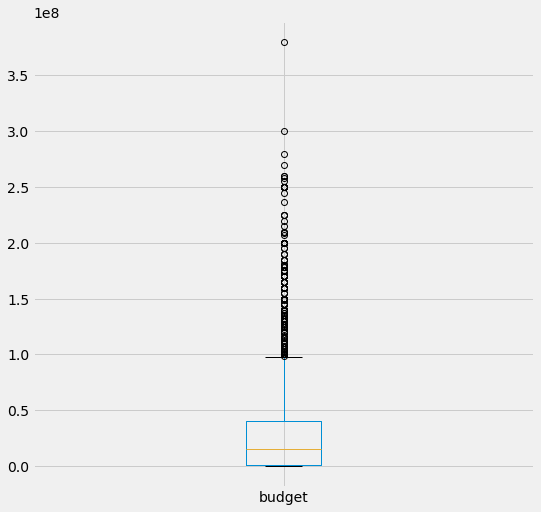

In [49]:
# Validando valores extremos mediante box plots
movies.boxplot(column = "budget", figsize = (8,8))
plt.show()

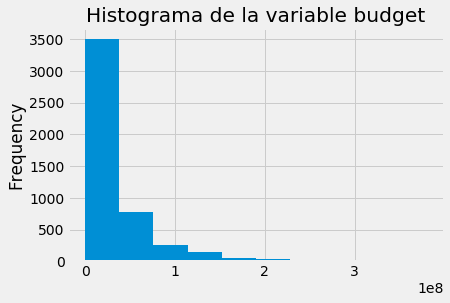

In [50]:
# Histograma de la variable budget

movies['budget'].plot.hist()
plt.title("Histograma de la variable budget")
plt.plot();

In [51]:
print(movies['budget'].kurt())
print(movies['budget'].skew())
print(movies['budget'].var())

7.607688447669056
2.429042312664617
1664219081523101.8


Con el presente histograma se puede ver que esta variable no tiene una distribucion normal, y más bien tiene una asimetría positiva, es decir, tiene un sesgo a la derecha. Por otro lado, se puede ver que la curtosis es de 7.60, por lo que la distribución es bastante picuda y luego desciende drásticamente. La varianza por otro lado es bastante alta, por lo que, los datos son altamente variables con respecto a su media. 

In [52]:
# Visualizando datos en order descendente

by_budget = movies[['title','budget']].sort_values('budget', ascending = False)
by_budget.head(20)

,title,budget
17,Pirates of the Caribbean: On Stranger Tides,380000000.0
1,Pirates of the Caribbean: At World's End,300000000.0
7,Avengers: Age of Ultron,280000000.0
10,Superman Returns,270000000.0
4,John Carter,260000000.0
6,Tangled,260000000.0
5,Spider-Man 3,258000000.0
13,The Lone Ranger,255000000.0
26,Captain America: Civil War,250000000.0
22,The Hobbit: The Desolation of Smaug,250000000.0


In [53]:
# Visualizando datos en order ascendente

by_budget = movies[['title','budget']].sort_values('budget', ascending = True)
by_budget.head(20)

,title,budget
4802,My Date with Drew,0.0
3645,"Gandhi, My Father",0.0
3646,Standard Operating Procedure,0.0
3647,Out of the Blue,0.0
3649,"Lovely, Still",0.0
3650,Tycoon,0.0
3651,Desert Blue,0.0
3655,Fascination,0.0
2419,"McFarland, USA",0.0
3658,The Cottage,0.0


A nivel de esta variable se puede ver que hay películas con mucho presupuesto, como es el caso de *Pirates of the Caribbean: On Stranger Tides*, *Pirates of the Caribbean: At World's End*, *Avengers: Age of Ultron* y la lista continúa, ya que se ve que en el top 20, todas estas pasan los $220MM. Por otro lado se puede ver que la media para esta variable es de $292MM, y este estadístico se ve afectado sin duda por la cantidad de valores atípicos que hay. 

Mientras que hay otras películas cuyo presupuesto se desconoce o es simplemente 0, lo que representa claramente un error, debido a que, aunque las películas sean de bajo presupuesto no pueden tener presupuesto 0, tal como es el caso de: *My Date with Drew*, *Gandhi, My Father*, *Standard Operating Procedure*, por mencionar algunas. 

A nivel de la columna 'budget' se ve que hay demasiados valores extremos por lo que, no se puede visualizar correctamente los datos. 

**Para este caso, después de haber validado la variable 'revenue' se vio que pasaba lo mismo y se va a proceder a comentar el código, para dejar dichas variables intactas y sólo se les aplicará normalización.** Se va a proceder a hacer feature engineering para poder analizar y se va a proceder a tratar los outliers mediante el rango intercuartílico y a imputarlos mediante la mediana ya que es la medida de tendencia central que es menos susceptible a valores extremos. 

In [54]:
# Tratando outliers

# Q3, Q2, Q1 = np.percentile(movies['budget'], [75,50, 25])
# IQR = Q3 - Q1
# sigma = 0.75*IQR
# print(sigma)
# print(Q2)

In [55]:
# Analizando desde el punto de dispersion de los datos 
# Lower_Bound = Q1 + 0.5 * IQR
# Upper_Bound = Q2 + 1.5 * IQR
# print(Lower_Bound)
# print(Upper_Bound)

**Tratando atipicos** (código comentado, no se trataron los atípicos).

En este caso se van a imputar todos aquellos datos que se alejen de la distribucion normal de los datos en hasta 1.5 veces en el tercer cuartil, mientras que todos aquellos que se alejen en 0.5 del primer cuartil serán imputados, ya que hay muchos datos con valores muy bajos. 

In [56]:
# Cambiando valores con atipicos muy altos y muy bajos
# movies['budget'] = [Q2 if x > Upper_Bound or x < Lower_Bound else x for x in movies['budget']]

In [57]:
# Visualizando datos en order descendente

# by_budget = movies[['title','budget']].sort_values('budget', ascending = True)
# by_budget.head(10)

In [58]:
# Validando valores extremos mediante box plots
# movies.boxplot(column = "budget", figsize = (8,8))
# plt.ylim(0, 80000000)
# plt.show()

In [59]:
# movies['budget'].describe()

In [60]:
# movies['budget'].plot.hist(color=sns.color_palette('muted',40))
# plt.title("Distribucion de la variable budget")
# plt.plot()

In [61]:
# print(movies['budget'].kurt())
# print(movies['budget'].skew())
# print(movies['budget'].var())

**Análisis (código comentado, no se procedió con estas imputaciones).**

Con el tratamiento que se le hizo a esta variable se puede ver que en realidad la distribución no cambió mucho, y es debido a que hay demasiadas películas de bajo presupuesto o con presupuestos nulos y otras con mucho presupuesto que lo que hacen es desvirtuar las medidas de posición central. 

Se puede ver que la distribución luego del tratamiento que se le hizo sigue presentando un sesgo a la derecha y asimetría positiva, ahora bien, la curtosis bajó considerablemente, sin embargo sigue siendo picuda y cae drásticamente. 

In [62]:
# Trabajando con la variable 'revenue'
movies['revenue'].describe()

# Con estos estadísticos tan básicos se puede ver que hay muchísimos outliers entre los datos, ya que, el mínimo es 
# de 0 y la mediana es menor a $194MM, mientras que se ve que el maximo es una pelicula que dejó una ganancia de $2787MM.  
# Con estos primeros estadísticos se ve la necesidad de tratar dicha variable para poder trabajar con ella. 

count    4.770000e+03
mean     8.282916e+07
std      1.632756e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.949239e+07
75%      9.367925e+07
max      2.787965e+09
Name: revenue, dtype: float64

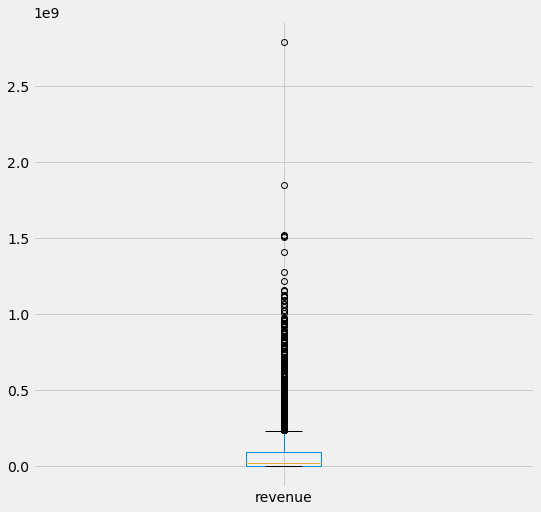

In [63]:
# Validando valores extremos mediante box plots
movies.boxplot(column = "revenue", figsize = (8,8))
plt.show()

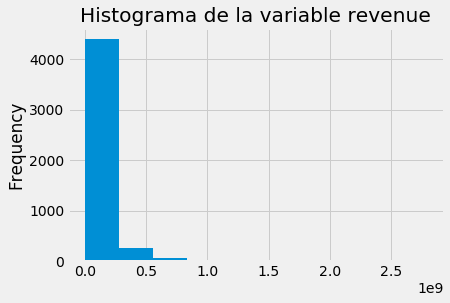

In [64]:
# Histograma de la variable revenue

movies['revenue'].plot.hist()
plt.title("Histograma de la variable revenue")
plt.plot();

In [65]:
print(movies['revenue'].kurt())
print(movies['revenue'].skew())
print(movies['revenue'].var())

32.940134672410416
4.431594899021526
2.6658909638872024e+16


In [66]:
# Visualizando datos en order descendente

by_budget = movies[['title','revenue']].sort_values('revenue', ascending = False)
by_budget.head(20)

,title,revenue
0,Avatar,2.787965e+09
25,Titanic,1.845034e+09
16,The Avengers,1.519558e+09
28,Jurassic World,1.513529e+09
44,Furious 7,1.506249e+09
7,Avengers: Age of Ultron,1.405404e+09
124,Frozen,1.274219e+09
31,Iron Man 3,1.215440e+09
546,Minions,1.156731e+09
26,Captain America: Civil War,1.153304e+09


In [67]:
# Visualizando datos en order descendente

by_budget = movies[['title','revenue']].sort_values('revenue', ascending = True)
by_budget.head(20)

,title,revenue
4802,My Date with Drew,0.0
3135,Good Intentions,0.0
3136,"The Good, The Bad, The Weird",0.0
3138,Gunless,0.0
3142,American Heist,0.0
3144,Plastic,0.0
3147,Re-Kill,0.0
3150,Heavy Metal,0.0
3151,Gentlemen Broncos,0.0
3152,Richard III,0.0


**Análisis**

Se puede ver con la variable 'revenue' que en realidad pasa lo mismo que con'budget', ya que en realidad no se tienen datos de cifras financieras para todas las películas, ya que no muestran en realidad el presupuesto ni las ganancias totales. Por esta razón no se va a proceder con el tratamiento de outliers de la variable 'budget' y se va a comentar el código, porque analizando, más de 1150 películas carecen de estos datos para ambas variables, es casi un 25% de los datos, y al ser tantos no se recomienda hacer imputaciones, entonces lo que se va a tratar de hacer es normalizar los datos para que así la distancia euclidea no sea tan grande una vez que se utilice el algoritmo de aprendizaje no supervisado (K-medias). 

Se puede apreciar que las películas que generan las mayores ganancias (al menos en este dataset) son: *Avatar*. *Titanic* y de *Avengers*, al igual que con la variable 'budget' las películas que presentan las ganancias en 0 son: *My Date with Drew*,*Good Intentions*,*The Good, The Bad, The Weird*, etc., con lo cual se puede entender que en la mayoría de los casos, para datos financieros se cuenta con los datos siempre y cuando las películas sean conocidas, para películas que no sean conocidas es probable que no hayan datos financieros.

En cuanto a esta variable 'revenue' se puede ver que sigue una distribución asimétrica positiva y con sesgo a la derecha, por otro lado se puede ver que la curtosis es de 32.94 por lo que, indica indica que la distribución es bastante picuda y luego desciende drásticamente. La varianza por otro lado es bastante alta, por lo que, los datos son altamente variables con respecto a su media. La media dice que son alrededor de $828MM lo que se ve afectado por la cantidad de valores en 0 con que cuenta.

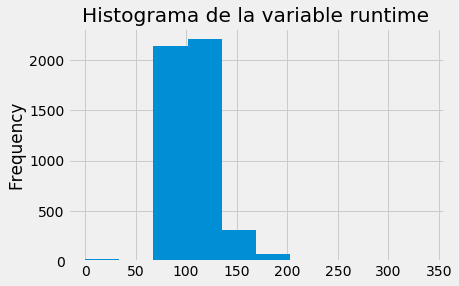

In [68]:
# Análisis de la variable 'runtime'

# Histograma de la variable runtime

movies['runtime'].plot.hist()
plt.title("Histograma de la variable runtime")
plt.plot();

In [69]:
movies['runtime'].describe()

count    4770.000000
mean      107.194340
std        22.012277
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

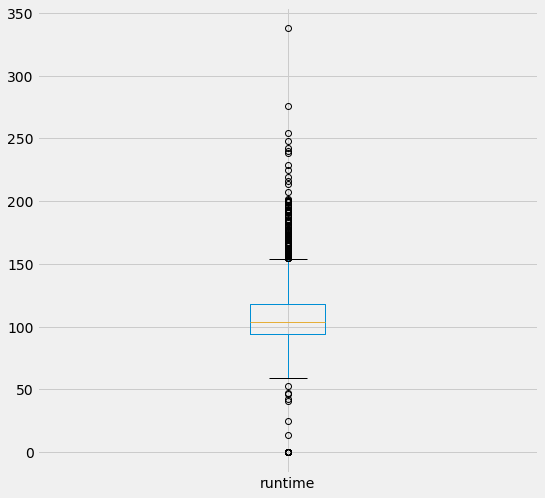

In [70]:
# Validando valores extremos mediante box plots
movies.boxplot(column = "runtime", figsize = (8,8))
plt.show()

In [71]:
# Visualizando datos en order descendente

by_budget = movies[['title','runtime']].sort_values('runtime', ascending = False)
by_budget.head(20)

,title,runtime
2384,Carlos,338.0
2631,The Company,276.0
1922,Gettysburg,254.0
1125,Cleopatra,248.0
2373,Hamlet,242.0
3510,Emma,240.0
3813,Gone with the Wind,238.0
1663,Once Upon a Time in America,229.0
4497,Woodstock,225.0
1109,Heaven's Gate,219.0


In [72]:
# Visualizando datos en order descendente

by_budget = movies[['title','runtime']].sort_values('runtime', ascending = True)
by_budget.head(20)

,title,runtime
4584,Love in the Time of Monsters,0.0
4581,Gory Gory Hallelujah,0.0
3809,How to Fall in Love,0.0
4502,Water & Power,0.0
4658,The Frozen,0.0
4313,Below Zero,0.0
3669,Should've Been Romeo,0.0
4558,Alleluia! The Devil's Carnival,0.0
3953,Fort McCoy,0.0
4318,Bleeding Hearts,0.0


In [73]:
print(movies['runtime'].kurt())
print(movies['runtime'].skew())
print(movies['runtime'].var())

8.913753437978443
1.027368738034314
484.540332809778


**Análisis** 

Se puede ver que esta variable cuenta con una media de 107 minutos. Y un máximo de 338 minutos lo que es equivalente a 5.63 horas. Por otro lado, la distribución presenta una ligera tendencia de normalidad, con algo de sesgo a la derecha. La curtosis es de 8.91 lo cual indica que la distribución es picuda y luego desciende drásticamente, la varianza es de 484 lo que indica que los datos son bastante variables con respecto a su media. En este caso tampoco se van a tratar los atípicos, sino que se hará mediante la normalización. 

En cuanto a las películas la que se tiene el mayor registro de minutos es *Carlos* con 338 minutos, seguida por *The Company* con 276 minutos y *Gettysburg* con 254 minutos. Por otro lado, las que presentan los tiempos más bajos -o en realidad que no se tienen datos reales sobre su duración- son: *Love in the Time of Monsters*, *Gory Gory Hallelujah*, *How to Fall in Love*, etc.

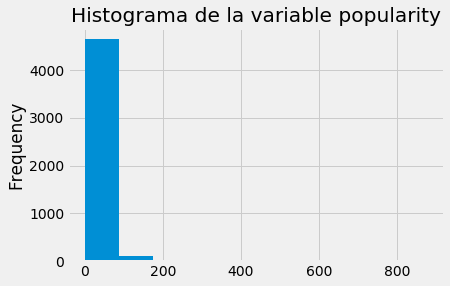

In [74]:
# Análisis de la variable 'popularity'

# Histograma de la variable popularity

movies['popularity'].plot.hist()
plt.title("Histograma de la variable popularity")
plt.plot();

In [75]:
movies['popularity'].describe()

count    4770.000000
mean       21.639401
std        31.877145
min         0.000372
25%         4.823252
50%        13.144125
75%        28.522434
max       875.581305
Name: popularity, dtype: float64

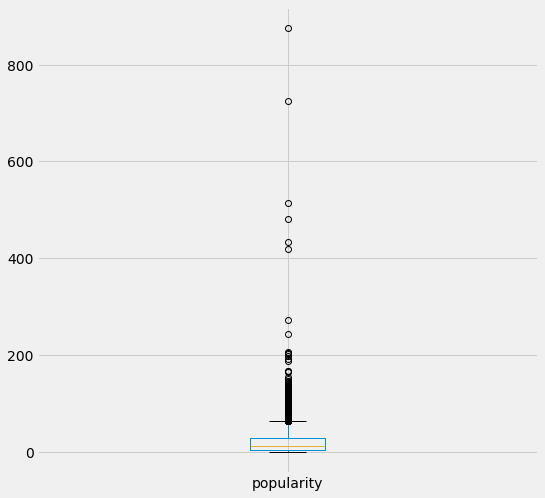

In [76]:
# Validando valores extremos mediante box plots
movies.boxplot(column = "popularity", figsize = (8,8))
plt.show()

In [77]:
# Visualizando datos en order ascendente

by_budget = movies[['title','popularity']].sort_values('popularity', ascending = True)
by_budget.head(20)

,title,popularity
3361,Alien Zone,0.000372
4727,Penitentiary,0.001117
4625,Midnight Cabaret,0.001389
4509,Love Letters,0.001586
4721,The Work and The Story,0.002388
4487,Hav Plenty,0.003142
4769,The Legend of God's Gun,0.003582
4462,The Young Unknowns,0.004922
4500,Carousel of Revenge,0.006069
4626,Anderson's Cross,0.006323


In [78]:
# Visualizando datos en order descendente

by_budget = movies[['title','popularity']].sort_values('popularity', ascending = False)
by_budget.head(20)

,title,popularity
546,Minions,875.581305
95,Interstellar,724.247784
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564
28,Jurassic World,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,271.972889
82,Dawn of the Planet of the Apes,243.791743
200,The Hunger Games: Mockingjay - Part 1,206.227151
88,Big Hero 6,203.734590


In [79]:
print(movies['popularity'].kurt())
print(movies['popularity'].skew())
print(movies['popularity'].var())

191.67947001170992
9.721296345186857
1016.1523990690004


**Análisis**

Con respecto a la variable *popularity* se puede observar que la media es de 21.63, el mínimo es un dato cercano a 0 y el máximo es de 875.58, además se puede observar que presenta un sesgo positivo, es decir, a la derecha, por otro lado la dsitribución es bastante picuda, dado a que su curtosis es alta y su varianza es alta, lo que indica que los datos varian con respecto a su media. 

Con el boxplot se puede observar que el rango intercuartílico va de 0 a menos de 50 (aproximadamente) pero hay algunas películas que tienen puntuaciones bastante altas de popularidad por lo que, hay muchos atípicos en la parte superior del boxplot, la mayoría mayores al tercer cuartil (mayores a 28.52).

Con respecto a las películas que aparecen con los mayores índices de popularidad son: *Minions*, *Interstellar*, *Deadpool* y las que su a vez presentan los índices más bajos de popularidad son: *Alien Zone*, *Penitentiary*, *Midnight Cabaret*, etc. 

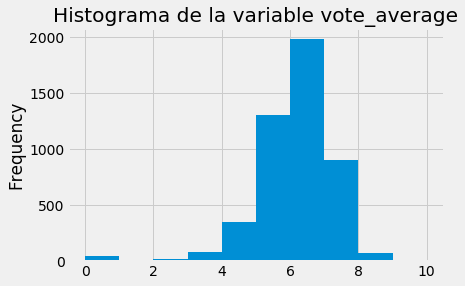

In [80]:
# Análisis de la variable 'vote_average'

# Histograma de la variable vote_average

movies['vote_average'].plot.hist()
plt.title("Histograma de la variable vote_average")
plt.plot();

In [81]:
movies['vote_average'].describe()

count    4770.000000
mean        6.109937
std         1.143451
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

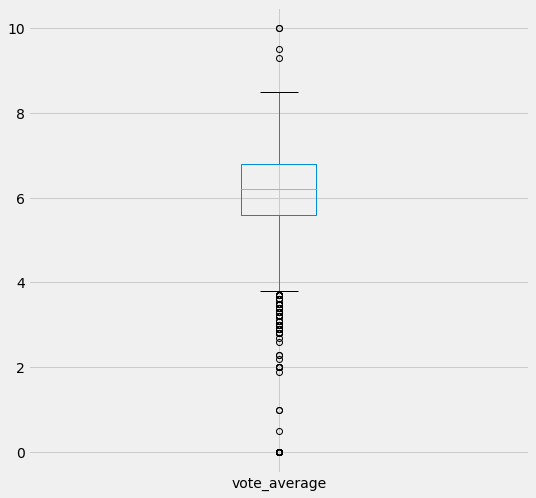

In [82]:
# Validando valores extremos mediante box plots
movies.boxplot(column = "vote_average", figsize = (8,8))
plt.show()

In [83]:
# Visualizando datos en order ascendente

by_budget = movies[['title','vote_average']].sort_values('vote_average', ascending = True)
by_budget.head(20)

,title,vote_average
4462,The Young Unknowns,0.0
4665,Western Religion,0.0
4309,The Blade of Don Juan,0.0
4785,Stories of Our Lives,0.0
4269,The Ballad of Gregorio Cortez,0.0
4660,Give Me Shelter,0.0
4500,Carousel of Revenge,0.0
4653,Rust,0.0
4508,The Harvest (La Cosecha),0.0
4550,The Outrageous Sophie Tucker,0.0


In [84]:
# Visualizando datos en order descendente

by_budget = movies[['title','vote_average']].sort_values('vote_average', ascending = False)
by_budget.head(20)

,title,vote_average
3519,Stiff Upper Lips,10.0
4045,"Dancer, Texas Pop. 81",10.0
3992,Sardaarji,9.5
2386,One Man's Hero,9.3
1881,The Shawshank Redemption,8.5
2970,There Goes My Baby,8.5
3337,The Godfather,8.4
2796,The Prisoner of Zenda,8.4
4755,Counting,8.3
662,Fight Club,8.3


In [85]:
print(movies['vote_average'].kurt())
print(movies['vote_average'].skew())
print(movies['vote_average'].var())

7.556961539691323
-1.849199374247775
1.3074793418184218


**Análisis**

En cuanto a la variable *vote_average* tiene una ligera distribución negativa a la izquierda y sesgo negativom de -1.84, además presenta una curtosis alta, lo que la hace picuda y que tienda a bajar dramáticamente. Asimismo, su varianza es de 1.30, lo que indica que sus datos son ligeramente variables con respecto a su media. La media es de 6.10 y el primer cuartil está representado por los votos que tienen 5.60 o menos. El máximo voto registrado es 10 y el mínimo es de 0, que en realidad no se piensa que 0 pueda ser un valor posible, a como sí puede ser 1, pero puede pasar que hayan películas que no han sido votadas y de ahí ese puntaje. Además en el boxplot se puede ver que esta vez hay más outliers en la parte inferior que superior. 

Por otro lado, las películas con los mayores puntajes en el top 3 son: *Stiff Upper Lips*, *Dancer, Texas Pop. 81*, *Sardaarji* y las películas que tienen por puntaje '0' son: *The Young Unknowns*, *Western Religion*, *The Blade of Don Juan*. 

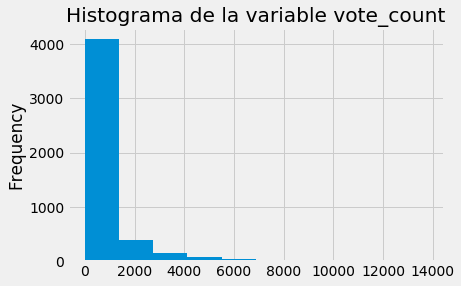

In [86]:
# Análisis de la variable 'vote_count'

movies['vote_count'].plot.hist()
plt.title("Histograma de la variable vote_count")
plt.show()

In [87]:
movies['vote_count'].describe()

count     4770.000000
mean       694.974214
std       1237.520109
min          0.000000
25%         56.000000
50%        239.000000
75%        742.000000
max      13752.000000
Name: vote_count, dtype: float64

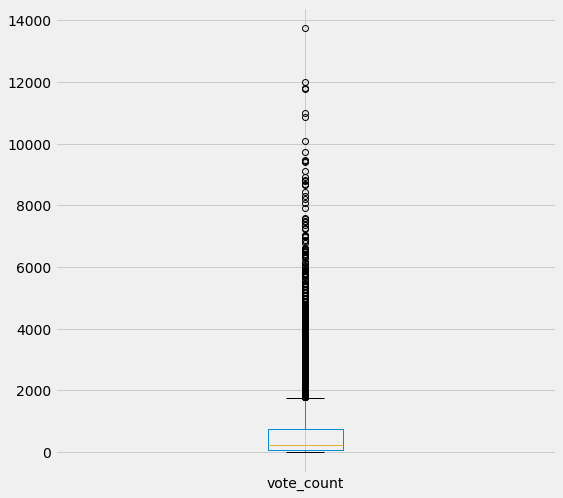

In [88]:
# Validando valores extremos mediante box plots
movies.boxplot(column = "vote_count", figsize = (8,8))
plt.show()

In [89]:
# Visualizando datos en order ascendente

by_budget = movies[['title','vote_count']].sort_values('vote_count', ascending = True)
by_budget.head(20)

,title,vote_count
4462,The Young Unknowns,0
4694,Archaeology of a Woman,0
4611,The Big Swap,0
4065,Mi America,0
1464,Black Water Transit,0
4186,A Beginner's Guide to Snuff,0
4625,Midnight Cabaret,0
4626,Anderson's Cross,0
3855,Time to Choose,0
4653,Rust,0


In [90]:
# Visualizando datos en order descendente

by_budget = movies[['title','vote_count']].sort_values('vote_count', ascending = False)
by_budget.head(20)

,title,vote_count
96,Inception,13752
65,The Dark Knight,12002
0,Avatar,11800
16,The Avengers,11776
788,Deadpool,10995
95,Interstellar,10867
287,Django Unchained,10099
94,Guardians of the Galaxy,9742
426,The Hunger Games,9455
127,Mad Max: Fury Road,9427


In [91]:
print(movies['vote_count'].kurt())
print(movies['vote_count'].skew())
print(movies['vote_count'].var())

19.79522164234497
3.8128685452248607
1531456.0200940021


**Análisis**

La variable *vote_count* tiene una distribución asimétrica a la derecha y posee sesgo positivo, por otro lado, su curtosis es de altamente picuda y desciende rápido después, presenta una alta varianza de sus datos con respecto a su media, que en este caso la media es de ~695 votos, con el boxplot podemos ver que el rango intercuartílico de los datos se aplica entre 0 y poco menos de 2000. Evidentemente se ve que hay muchísimos datos atípicos mayores a los 2000 votos, esto porque pueden haber películas más votadas que otras que no son tan conocidas o no han sido tan votadas por los usuarios. 

Finalmente se puede ver que la película con mayor cantidad de votos es *Inception* con 13752 votos, de segundo lugar *The Dark Knight* con 12002 y de tercer lugar *Avatar* con 11800 respectivamente. Se tienen otras películas como: *The Young Unknowns*, *Archaeology of a Woman*, *The Big Swap* que no presentan votos por los usuarios o que están nulos.

## Matriz de Correlación

Después de haber estudiado con detalle cada una de las variables cuantitativas discretas y continuas es momento de utilizar la matriz de correlación, para con ello ver si hay dependencia entre las variables, por ello solo se van a utilizar estas y además se utilizarán las varibles de: *day*, *month* y *year* que fueron obtenidas utilizando técnicas de feature engineering. 

In [92]:
matriz = movies[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'month', 'day']]

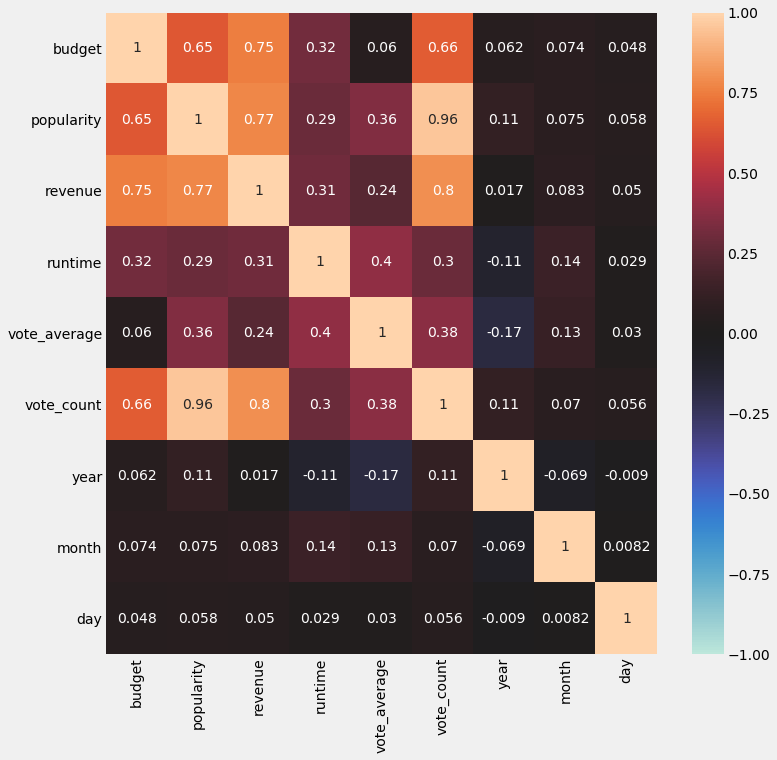

In [93]:
# Utilizando coeficiente de Spearman para analizar variables aleatorias (continuas como discretas)
f,ax = plt.subplots(figsize=(11,11))
sns.heatmap(matriz.corr(method='spearman'),annot=True,vmin=-1, vmax=1, center= 0)
plt.show()

**Análisis**

Como se puede apreciar en la matriz de correlaciones, el método utilizado es el de spearman, ya que es útil para identificar las correlaciones que pueden existir entre variables cuantitativas, ya sean estas continuas o discretas. 

Habiendo dicho esto se tiene lo siguiente:

1. Se muestra una correlación positiva directa entre popularity y budget, es decir, entre más presupuesto tenga asignada una película más popular va a ser, lo mismo aplica si la película tiene bajo presupuesto, no será tan ppopular. Esto se puede constatar mediante el EDA previo, ya que efectivamente, películas con altos presupuestos eran muy populares. 
2. Budget y Revenue también muestras correlaciones positivas, es decir, entre más presupuesto tenga una película mayor cantidad de ganancias dará. 
3. Con Popularity y Revenue pasa lo mismo que con budget, ya que si una aumenta la otra también lo hará y si una disminuye la otra también.
4. Se observa correlaciones positivas entre vote count y budger, popularity y revenue. Es de esperar que el conteo de votos de las películas sea mayor para aquellas que son más populares producto a que tienen más presupuesto y por ende generan más ganancias. 
5. Se observa correlaciones postivas entre vote_count y runtime y vote_count y vote_average. Al parecer entre más duración tenga una película tendrá mayor cantidad de votos y el vote_average subirá si tiene mayor vote_count, lo cual es de esperar porque son variables dependientes. 
6. Se observa una leve correlación negativa entre runtime y year y vote_average y year, al parecer entre mayor el año va a tener menos duración la película y viceversa, al igual que el vote_average, entre mayor el año menor vote_average y viceversa, aunque la correlación es tan súmamente baja que podemos decir que no existe casi dependencia lineal entre estas variables. 
7. Para las demás variables parece no haber ningún tipo de correlación o dependencia lineal entre cada una de ellas. 

Habiendo hecho este análisis es necesario escoger cuáles variables será necesario quitar para atenuar o tratar de dismunuir el ruido producto de dependencias lineales que pueden causar sobre ajustes, por ello:

In [94]:
matriz.var()

budget          1.664219e+15
popularity      1.016152e+03
revenue         2.665891e+16
runtime         4.845403e+02
vote_average    1.307479e+00
vote_count      1.531456e+06
year            1.546336e+02
month           1.167673e+01
day             7.438370e+01
dtype: float64

Se va a proceder a eliminar las variables de *budget* y de *popularity* para tratar de quitar un poco de dependencia entre los datos, ya que se ve que son las que presentan las mayores correlaciones. No se va a eliminar *vote_count* ni *budget* porque ambas son variables importantes desde un punto de vista de conocer cómo se comportan las películas desde el público y sus votos promedios y por el lado de las productoras cinematográficas y el dinero que destinan a sus películas. 

In [95]:
matriz1 = movies[['runtime', 'month', 'day', 'popularity', 'vote_average', 'year']]

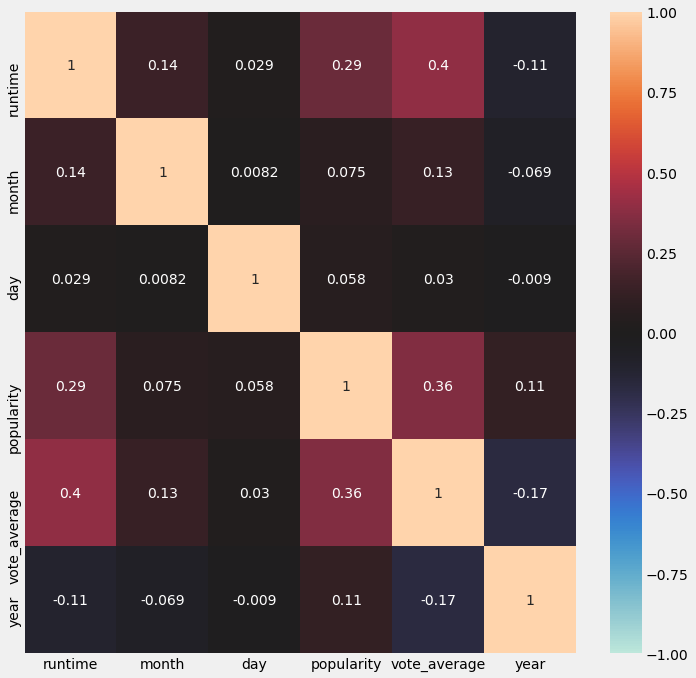

In [96]:
# Utilizando coeficiente de Spearman para analizar variables aleatorias (continuas como discretas)
f,ax = plt.subplots(figsize=(11,11))
sns.heatmap(matriz1.corr(method='spearman'),annot=True,vmin=-1, vmax=1, center= 0)
plt.show()

**Análisis** 

Se puede ver que ya no hay tantas correlaciones positivas como se tenían en un inicio. No se va a proceder a hacer un ANOVA, ya que no se ve necesario, aparte que ninguna de las variables del presente dataset es binaria y no se presta para hacer clasificación mediante datos etiquetados. 

# Selección del Algoritmo para clusterización

Como se indicó previamente, al ser este dataset muy enfocado en variables tanto cuantitativas como cualitativas, pero sin etiquetas, es por ello que se elige un modelo de aprendizaje no supervisado, ya que lo que más interesa en este caso es poder descubrir "clusters" o aglomeraciones entre los datos para con ello poder ver si se pueden descubrir características entre las distintas películas. 

Es por ello que se va a proceder a utilizar un K-Medias ya que mediante la presente imagen https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html es el más recomendado, debido a que se pueden conocer la cantidad de clusters finales mediante el codo de Jambú y se cuentan con menos de 10K observaciones, por lo que, se elige el algoritmo descrito que tratará de ubicar cada uno de los datos en un centroide específico y así mediante el criterio de la inercia minimizar la distancia intra-cluster y maximizar la distancia inter-cluster.

#### Renombrando dataset

In [97]:
data = matriz1

In [98]:
# Importando bibliotecas para K-Means

from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from math import pi

#### Función para graficar los gráficos de Barras para la interpretación de clústeres

In [99]:
def bar_plot(centros, labels, cluster = None, var = None):
    from math import ceil, floor
    from seaborn import color_palette
    colores = color_palette()
    minimo = floor(centros.min()) if floor(centros.min()) < 0 else 0
    def inside_plot(valores, labels, titulo):
        plt.barh(range(len(valores)), valores, 1/1.5, color = colores)
        plt.xlim(minimo, ceil(centros.max()))
        plt.title(titulo)
    if var is not None:
        centros = np.array([n[[x in var for x in labels]] for n in centros])
        colores = [colores[x % len(colores)] for x, i in enumerate(labels) if i in var]
        labels = labels[[x in var for x in labels]]
    if cluster is None:
        for i in range(centros.shape[0]):
            plt.subplot(1, centros.shape[0], i + 1)
            inside_plot(centros[i].tolist(), labels, ('Cluster ' + str(i)))
            plt.yticks(range(len(labels)), labels) if i == 0 else plt.yticks([]) 
    else:
        pos = 1
        for i in cluster:
            plt.subplot(1, len(cluster), pos)
            inside_plot(centros[i].tolist(), labels, ('Cluster ' + str(i)))
            plt.yticks(range(len(labels)), labels) if pos == 1 else plt.yticks([]) 
            pos += 1

#### Función para graficar los gráficos tipo Radar para la interpretación de clústeres

In [100]:
def radar_plot(centros, labels):
    from math import pi
    centros = np.array([((n - min(n)) / (max(n) - min(n)) * 100) if 
                        max(n) != min(n) else (n/n * 50) for n in centros.T])
    angulos = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
    angulos += angulos[:1]
    ax = plt.subplot(111, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angulos[:-1], labels)
    ax.set_rlabel_position(0)
    plt.yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
           ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"], 
           color = "grey", size = 8)
    plt.ylim(-10, 100)
    for i in range(centros.shape[1]):
        valores = centros[:, i].tolist()
        valores += valores[:1]
        ax.plot(angulos, valores, linewidth = 1, linestyle = 'solid', 
                label = 'Cluster ' + str(i))
        ax.fill(angulos, valores, alpha = 0.3)
    plt.legend(loc='upper right', bbox_to_anchor = (0.1, 0.1))

#### Normalizando y centrando los datos

Se procede a normalizar y centrar los datos, ya que se encuentran en escalas muy diferentes y con altos valores atípicos (muy bajos o muy altos).

In [101]:
print(data.shape)

(4770, 6)


In [102]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(data) 
data.loc[:,:] = scaled_values
print(data)

       runtime     month       day  popularity  vote_average      year
0     2.490038  1.520803 -0.604764    4.040879      0.953410  0.529021
1     2.808076 -0.527919  0.438872    3.684631      0.691019  0.368170
2     1.853963  0.935454  1.250589    2.689901      0.166236  1.011574
3     2.626340  0.057430  0.090993    2.844767      1.303265  0.770297
4     1.127019 -1.113268 -0.952643    0.699245     -0.008691  0.770297
...        ...       ...       ...         ...           ...       ...
4798 -1.190112  0.642779 -1.300522   -0.231212      0.428627 -0.838212
4799 -1.008377  1.520803  1.250589   -0.658749     -0.183619  0.689872
4800  0.581812  0.935454 -0.256886   -0.633590      0.778482  0.850723
4801 -0.417735 -0.527919 -1.416482   -0.652021     -0.358546  0.770297
4802 -0.781207  0.350105 -1.184562   -0.618361      0.166236  0.207319

[4770 rows x 6 columns]


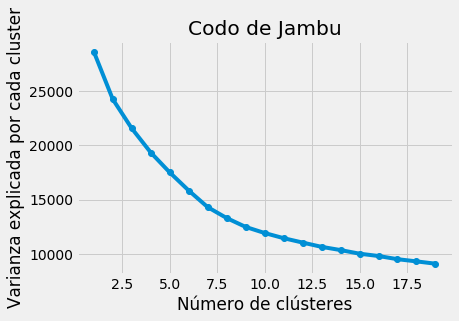

In [103]:
Nc = range(1, 20)
kmediasList = [KMeans(n_clusters=i) for i in Nc]
varianza = [kmediasList[i].fit(data).inertia_ for i in range(len(kmediasList))]
plt.plot(Nc,varianza,'o-')
plt.xlabel('Número de clústeres')
plt.ylabel('Varianza explicada por cada cluster')
plt.title('Codo de Jambu');

**Análisis:**

En realidad no hay mucha claridad de cuántos deberían de ser el número de clústers, ya que se ve que desciende pero no se "quiebra" sin embargo se puede apreciar que quizá con 3, 4, 5, 6, 7 o 10 parecen un número aceptable, por ello se trabajará con 3 clústers en un inicio y se irá evaluando conforme se obtengan los resultados para validar cuál es el número ideal de clústers a usar.

#### Ejecutando K-Medias con 3 instancias y 3000 iteraciones

In [104]:
kmedias = KMeans(n_clusters=3, max_iter=3000, n_init=100) # Declaración de la instancia
kmedias.fit(data)
print(kmedias.predict(data))
centros = np.array(kmedias.cluster_centers_)
print(centros)

[1 1 1 ... 2 2 2]
[[-0.24604088 -0.18951862  0.90384631 -0.11022423 -0.09634557  0.21340452]
 [ 1.08775043  0.5613371   0.00160038  0.58903365  0.77839641 -0.82089333]
 [-0.34147448 -0.11624955 -0.86742863 -0.20697563 -0.32079454  0.23111921]]


#### Bar Plot con tres clusters

In [105]:
centros = np.array(kmedias.cluster_centers_)
print(centros)

[[-0.24604088 -0.18951862  0.90384631 -0.11022423 -0.09634557  0.21340452]
 [ 1.08775043  0.5613371   0.00160038  0.58903365  0.77839641 -0.82089333]
 [-0.34147448 -0.11624955 -0.86742863 -0.20697563 -0.32079454  0.23111921]]


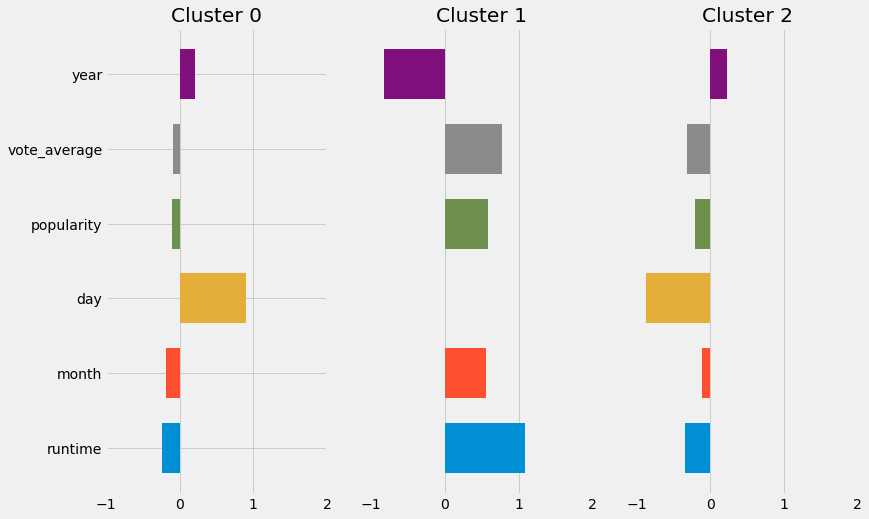

In [106]:
plt.figure(1, figsize = (12, 8))
bar_plot(centros, data.columns)

#### Radar Plot con 3 clusters

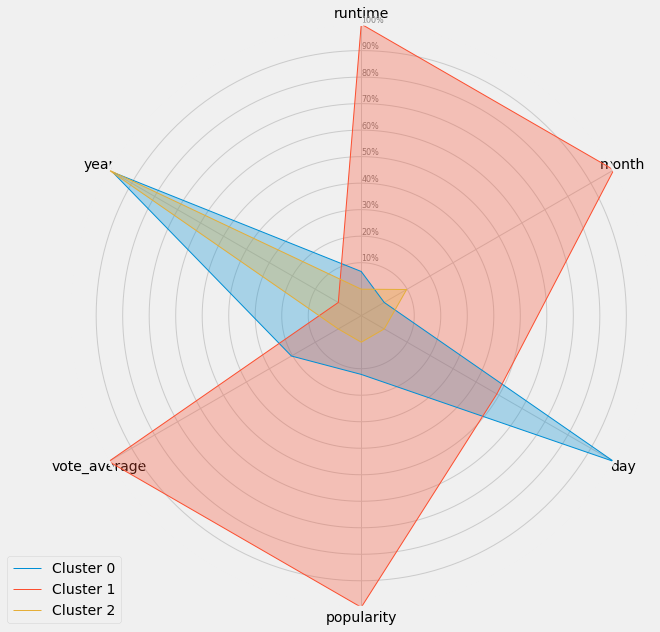

In [107]:
plt.figure(1, figsize = (10, 10))
radar_plot(centros, data.columns)

#### Dibujando resultado de k-Medias sobre plano principal

(4770, 6)
(4770, 2)


Text(0.5, 1.0, '3 Cluster K-Medias')

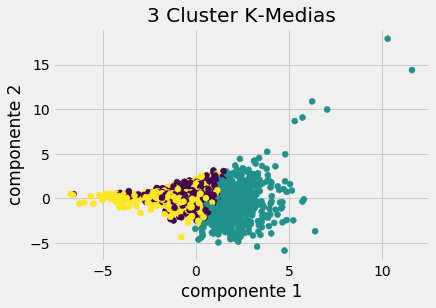

In [108]:
pca = PCA(n_components=2)
componentes = pca.fit_transform(data)
componentes
print(data.shape)
print(componentes.shape)
plt.scatter(componentes[:, 0], componentes[:, 1],c=kmedias.predict(data))
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('3 Cluster K-Medias')

#### Análisis

Habiendo utilizado 3 clústers se ve que los resultados no son favorables, ya que los clústers se traslapan y se ve como los datos no quedan claros, salvo en el clúster de color turquesa oscuro, por lo que, se va a proceder a utilizar 4 clústers con la finalidad de ver si mejora la separación. 

#### Ejecutando K-Medias con 4 instancias y 3000 iteraciones

In [109]:
kmedias = KMeans(n_clusters=4, max_iter=3000, n_init=100) # Declaración de la instancia
kmedias.fit(data)
print(kmedias.predict(data))
centros = np.array(kmedias.cluster_centers_)
print(centros)

[3 3 3 ... 3 0 0]
[[-0.35820549 -0.08346857 -0.89081114 -0.25264426 -0.34835213  0.24966009]
 [-0.29137204 -0.25455242  0.88237688 -0.18247771 -0.14601148  0.22100248]
 [ 0.45312072  0.14508425  0.01535441 -0.13483505  0.61310044 -2.52653453]
 [ 1.1022182   0.60888024  0.05881158  0.93709025  0.72181152  0.19514449]]


#### Bar Plot con 4 clústers

In [110]:
centros = np.array(kmedias.cluster_centers_)
print(centros)

[[-0.35820549 -0.08346857 -0.89081114 -0.25264426 -0.34835213  0.24966009]
 [-0.29137204 -0.25455242  0.88237688 -0.18247771 -0.14601148  0.22100248]
 [ 0.45312072  0.14508425  0.01535441 -0.13483505  0.61310044 -2.52653453]
 [ 1.1022182   0.60888024  0.05881158  0.93709025  0.72181152  0.19514449]]


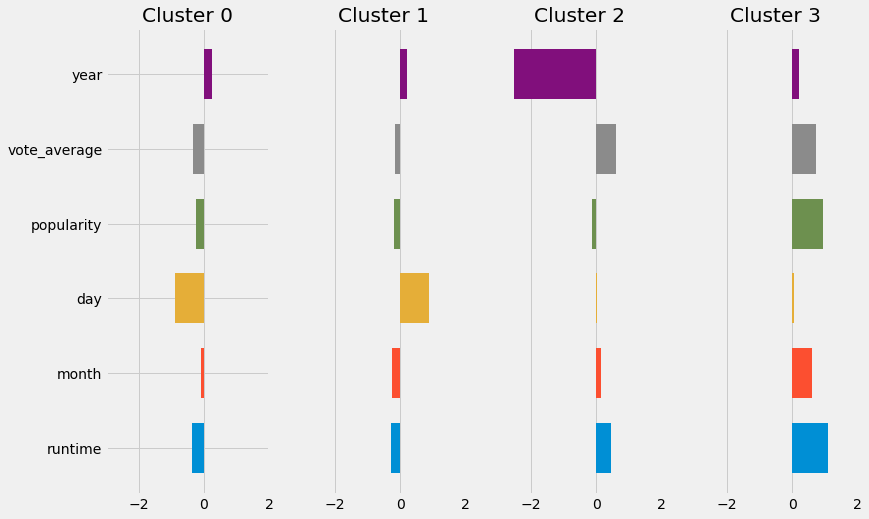

In [111]:
plt.figure(1, figsize = (12, 8))
bar_plot(centros, data.columns)

#### Radar Plot con 4 Clústers

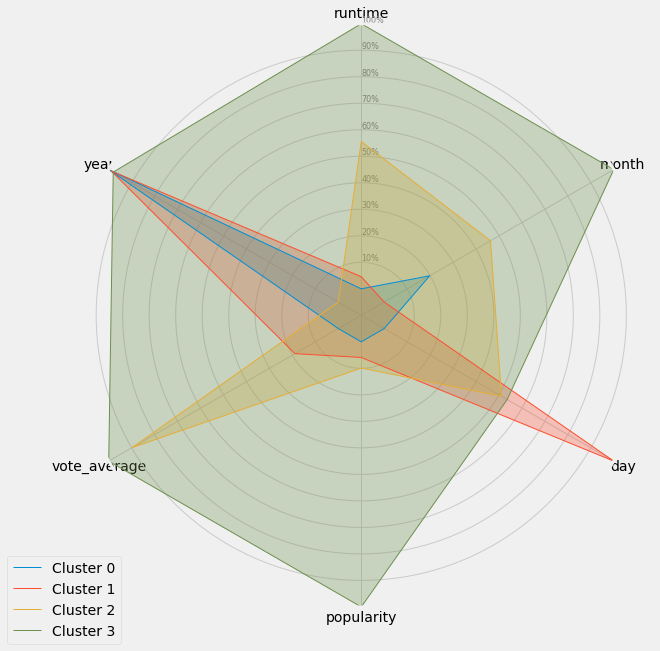

In [112]:
plt.figure(1, figsize = (10, 10))
radar_plot(centros, data.columns)

#### Dibujando resultado de K-Medias sobre plano principal

(4770, 6)
(4770, 2)


Text(0.5, 1.0, '3 Cluster K-Medias')

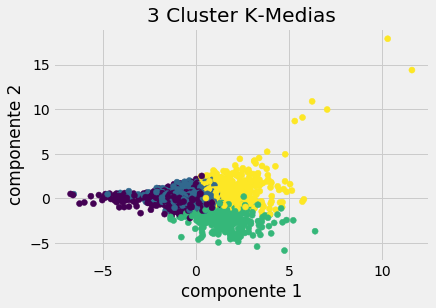

In [113]:
pca = PCA(n_components=2)
componentes = pca.fit_transform(data)
componentes
print(data.shape)
print(componentes.shape)
plt.scatter(componentes[:, 0], componentes[:, 1],c=kmedias.predict(data))
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('3 Cluster K-Medias')

#### Análisis

Los resultados no mejoran y más bien se ve como cada vez los clústers se confunden más entre sí. El problema principal es que las variables elegidas todas presentan diferentes tipos de distribuciones y outliers, por lo que, el algoritmo de K-Medias al ser un algoritmo paramétrico que trabaja mejor con distribuciones gaussianas está teniendo un rendimiento deficiente, porque aunque se hayan estandarizado las variables, no se trataron los sesgos o altas varianzas que presentan, por lo que, se va a optar por utilizar otro método para poder tratarlas y se va a utilizar *Power Transfomer* con el método "Yeo-Johnson" ya que es un método que tolera valores en las variables que tengan cifras negativas o cero (como es el caso de este dataset).

#### Utilizando transformación Gaussiana con método Yeo-Johnson

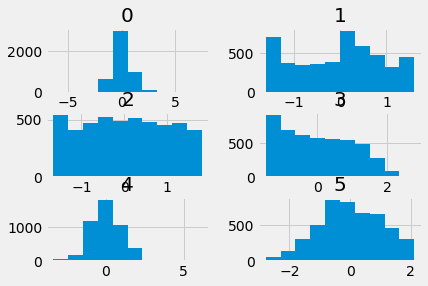

In [114]:
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import PowerTransformer

# Trabajando únicamente con valores numéricos, en este caso se van a llevar todas las variables a distribuciones gaussianas. 
data = matriz1

# Utilizando el método Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
data = pt.fit_transform(data)

# Convirtiendo el array de nuevo en DataFrame
dato = DataFrame(data)

# Ploteando histogramas de las variables
dato.hist()
plt.show()

In [115]:
dato.head(3)

,0,1,2,3,4,5
0,2.233228,1.601645,-0.601025,2.208896,1.116924,0.504989
1,2.476762,-0.568305,0.443919,2.165996,0.714747,0.197130
2,1.730352,0.936730,1.246932,2.010121,0.011109,1.654807


**Análisis**

Se puede ver que ahora las variables siguen una distribución más gaussiana que antes. 

#### Gráfico de Codo de Jambú

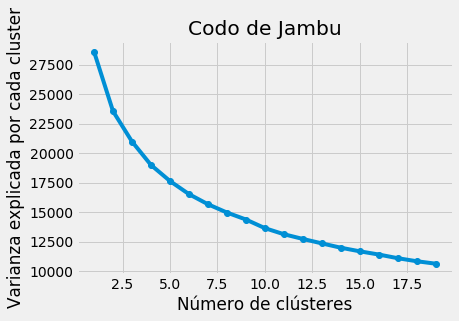

In [116]:
Nc = range(1, 20)
kmediasList = [KMeans(n_clusters=i) for i in Nc]
varianza = [kmediasList[i].fit(dato).inertia_ for i in range(len(kmediasList))]
plt.plot(Nc,varianza,'o-')
plt.xlabel('Número de clústeres')
plt.ylabel('Varianza explicada por cada cluster')
plt.title('Codo de Jambu')
plt.show()

**Análisis:**

En realidad ahora se ve que el codo se quiebra a partir de 2, sin embargo se va a intentar con 3 clústers ya que se ve cierta estabilización a partir de 2.5 (eje **X**).

#### Ejecutando K-Medias con 3 instancias y 3000 iteraciones

In [117]:
# Ejecutando k-medias con 3 clusters
kmedias = KMeans(n_clusters=3, max_iter=3000, n_init=100)  # Declara la instancia de clase
kmedias.fit(dato)
print(kmedias.predict(dato))
centros = np.array(kmedias.cluster_centers_)
print(centros) 

[2 0 0 ... 1 1 1]
[[ 0.08981887 -0.14344445  0.1429129   0.87634454  0.18908713  0.78015883]
 [-0.49670003 -0.22092726 -0.14890054 -0.76482221 -0.60362191 -0.01524971]
 [ 0.73059662  0.53961429  0.08326255  0.26114815  0.79431113 -0.88746769]]


#### Gráfico Bar plot para la interpretación

#### Interpretación con 3 clústeres - Gráficos de Barras

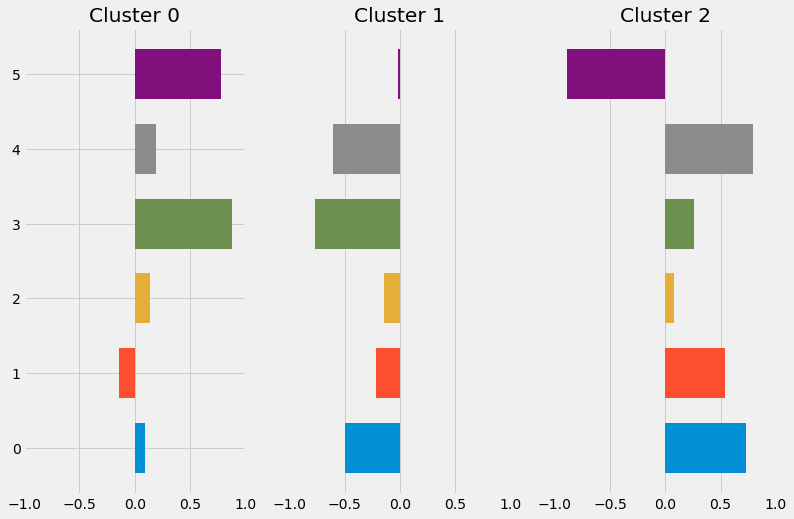

In [118]:
plt.figure(1, figsize = (12, 8))
bar_plot(centros, dato.columns)

#### Interpretación 3 Clústeres - Gráfico Radar plot

0 = runtime 1 = month 2 = day 3 = popularity 4 = vote_average 5 = year


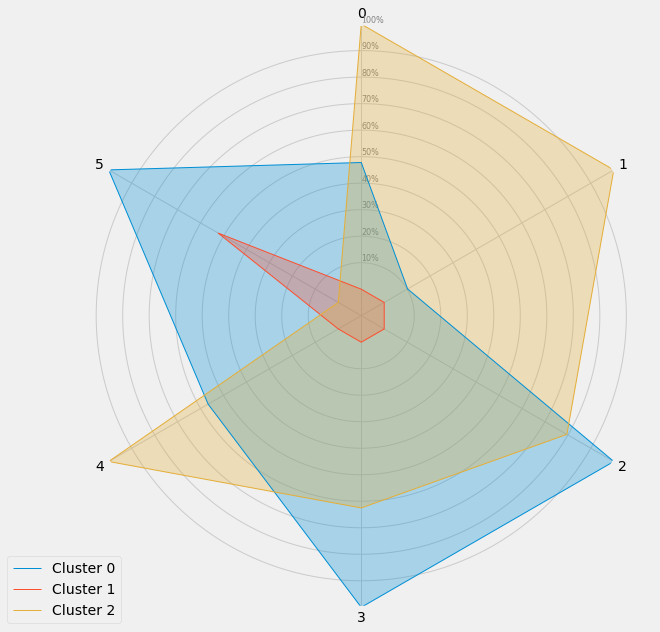

In [119]:
plt.figure(1, figsize = (10, 10))
radar_plot(centros, dato.columns)
print("0 = runtime", "1 = month", "2 = day" , "3 = popularity" , "4 = vote_average", "5 = year")

#### Graficando el resultado de k-medias sobre el plano principal

[[-3.23414283 -0.91096918]
 [-2.6966949  -1.31860409]
 [-1.97342478 -2.23979035]
 ...
 [-0.20616332  0.01104999]
 [ 1.65640076 -0.08932997]
 [ 1.0361132   0.90517855]]
(4770, 6)
(4770, 2)


Text(0.5, 1.0, '3 Cluster K-Medias')

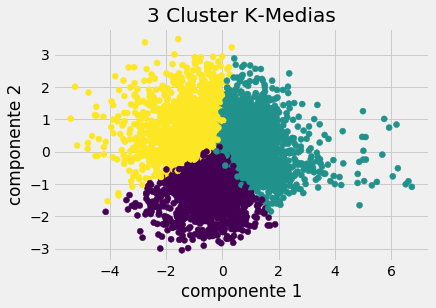

In [120]:
pca = PCA(n_components=2)
componentes = pca.fit_transform(dato)
print(componentes)
print(dato.shape)
print(componentes.shape)
plt.scatter(componentes[:, 0], componentes[:, 1],c=kmedias.predict(dato))
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('3 Cluster K-Medias')

#### **Análisis con resultados finales:**

Utilizando tres clústers se obtiene un buen desempeño relativamente de cada uno de los clústers, ya que se puede apreciar que se forma un clúster de color amarillo a la derecha, otro de color morado abajo y otro de color turquesa oscuro a la izquierda, aunque se ve que hay cierto traslape a nivel de clústers, no son tantos como los que aparecían con el otro tipo de estandarización. 

Analizando con detalle la interpretación que se puede obtener gracias al radar: 

1. Clúster 1 (Clúster 0 en el radar): este se caracteriza por tener los días, la popularidad, y el año más alto y se ve que llegan a un 100%, mientras que otras variables como el *runtime* se ve que llega a un 50% y la variable *month* se ve baja también (cerca de un 10%), así como la variable *vote_average* que no llega al 50%. Este clúster va a estar representado por todas aquellas películas que se estrenan a final de mes (días 29, 30, 31), cuentan con la popularidad más alta (mayor a 800) y se han estrenado en años recientes (a partir del 2010) pero son películas que no tienen una alta duración, sino que son películas de duración promedio (en promedio duran 169 minutos) y se estrenan en el primer semestre de cada año y no reciben un promedio de voto tan alto (en promedio entre un 5 y un 6), sino que se quedan en un voto medio. Estas películas se pueden catalogar como las películas "populares". 

2. Clúster 2 (Clúster 1 en el radar): este se caracteriza por tener todas aquellas películas que tienen una muy alta duración, meses altos, y el vote_average es alto también, sin embargo el year es bajo, y su popularidad ronda el 50% y el día representa el 80%. Este clúster va a estar representado por todas aquellas películas que tienen una alta duración (más de 169 minutos), es decir las películas largas y son aquellas que se estrenan en el último trimestre del año (octubre, noviembre y diciembre) y reciben votos promedios altos (más de 7), por otro lado son películas antiguas y su popularidad no es tan elevada (entre 400 y 500) pero se han estrenado en días posteriores a los 24 de cada mes. Estas películas se pueden catalogar como las famosas películas de "culto". 

3. Clúster 3 (Clúster 2 en el radar): este se caracteriza por tener todas aquellas películas que tienen un año de estreno intermedio, es decir, ni muy reciente ni muy antiguo, pero presenta bajos índices en todo lo demás; es decir son películas que pueden andar en su estreno entre 1950 y 1990, pero que no son películas con mucha duración (menores a 90 minutos), tienen poca popularidad (menos de 100), se estrenan a principios de año y los primeros días del mes y el voto promedio tampoco ha sido bueno (menos de 3), sino que ha sido bajo. Estas películas se pueden catalogar como las películas de "relleno". 




## Sistema de Recomendación

En años recientes gracias al rápido crecimiento de la recopilación de datos por parte de las empresas, ha llevado a una nueva era de información. Los datos se utilizan para crear sistemas más eficientes y aquí es donde entran en juego los sistemas de recomendación. Los sistemas de recomendación son un tipo de sistemas de filtrado (perfilamiento) de información, ya que mejoran la calidad de los resultados de la búsqueda de los usuarios y proporcionan elementos que son más relevantes en los elemento de búsqueda o se relacionan con el historial de búsqueda del interesado. 

Se utilizan para predecir la calificación o preferencia que un usuario le daría a un artículo. Casi todas las grandes empresas de tecnología los han aplicado de una forma u otra: Amazon lo usa para sugerir productos a los clientes, YouTube lo usa para decidir qué video reproducir a continuación, Facebook lo usa para recomendar páginas que les gusten y personas a seguir y ahora para vender productos o mostrar publicidad. Además, empresas como Netflix, Disney+, Amazon Prime, HBO, Spotify, Apple Music, etc.,  dependen en gran medida de la efectividad de sus motores de recomendación para sus ventas y para que las personas sigan comprando/consumiendo sus producto (como el presente trabajo se va a desarrollar haciendo énfasis en películas los ejemplos que se darán serán en este ámbito). 

En la actualidad existen básicamente tres tipos de sistemas de recomendación:

1. Filtrado demográfico: ofrece recomendaciones generalizadas a cada usuario, según la popularidad de la película y/o el género. El sistema recomienda las mismas películas a usuarios con características demográficas similares. Dado que cada usuario es diferente, este enfoque se considera demasiado simple. La idea básica detrás de este sistema es que las películas que son más populares y aclamadas por la crítica tendrán una mayor probabilidad de gustar a la audiencia promedio ya que se basa en filtrado comunitario. 

2. Filtrado basado en contenido: sugieren elementos similares basados en un elemento en particular. Este sistema utiliza metadatos de elementos específicos, por ejemplo: género, director, descripción, actores, etc., para hacer estas recomendaciones. La idea general detrás de estos sistemas de recomendación es que si a una persona le gustó una película en particular, a él o ella también le gustará un artículo similar que cumpla con condiciones similares a las ya analizadas. 

3. Filtrado colaborativo: este sistema relaciona a personas con intereses similares y proporciona recomendaciones basadas en esta correspondencia. Los filtros colaborativos no requieren metadatos de elementos como sus homólogos basados en contenido.

<img src=https://www.fundacionctic.org/sites/default/files/inline-images/2_7.png>

                                                                  Fuente: Imagen tomada de fundacionctic.org

#### Importando Dataset original

In [121]:
movie.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


### Sistema de Recomendación con Filtro Demográfico

Antes de proceder a trabajar este sistema se necesita una métrica para puntuar o calificar las películas en el dataset. Entonces lo primero que se debe hacer es:

* Calcular la puntuación de cada película
* Ordenar las puntuaciones y recomendar la película mejor calificada (según score) a los usuarios.

Para este caso el presente dataset contiene la variable llamada *vote_average* que facilita ya las calificaciones promedio de cada película y que se puede usar como puntuación, pero usar esto no será lo suficientemente justo, ya que una película con una calificación promedio de 8.9 y solo 3 votos no puede considerarse mejor que una película con una calificación promedio de 7.8 pero con 40 votos, en este punto también se debe recordar la cantidad de outliers que se tienen. Dado lo anterior se propone usar la calificación ponderada de IMDB (**WR**) que se da como:

$(WR) = (\frac{v}{v+m}\cdot{R}) + (\frac{m}{v+m}\cdot{C})$

Donde: 


$ v $ es el número de votos por película.

$ m $ es el mínimo de votos requeridos para ser enlistado en el chart. 

$ R $ es el rating promedio de la película.

$ C $ es el voto promedio en todo el dataset.

Fuente: https://farm3.static.flickr.com/

En el presente dataset ya se encuentran las variables *vote_count* que es $ v $ y *vote_average* que es $R$, por ende solo queda calcular $C$.


In [122]:
C = movie['vote_average'].mean()
print(C)

6.092171559442011


Por lo tanto, la calificación media para todas las películas es aproximadamente 6 en una escala de 10. El siguiente paso es determinar un valor apropiado para $m$, que son los votos mínimos requeridos para aparecer en el chart. Se va a proceder a utilizar el percentil 90 como el límite. En otras palabras, para que una película aparezca en el chart que se está construyendo, debe tener más votos que al menos el 90% de las películas del dataset. 

In [123]:
m = movie['vote_count'].quantile(0.9)
print(m)

1838.4000000000015


In [124]:
# Se procede a filtrar por las películas que califican para el chart en construcción

chart = movie.copy().loc[movie['vote_count'] >= m]
chart.shape

(481, 20)

Se puede ver que hay 481 películas que califican para estar en el chart en construcción. Ahora, se necesita calcular una métrica para cada película calificada. Para hacer esto, se definirá una función, weighted_rating () y también se definirá una nueva puntuación de función, cuyo valor se calculará aplicando esta función al DataFrame de películas calificadas:

In [125]:
def weighted_rating (x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Cálculo basado en la fórmula de IMDB
    return (v/(v+m) * R) + (m/(m+v) * C)

In [126]:
# Definiendo una nueva variable 'score' y calculando sus valores con la funcion 'ponderacion'
chart['score'] = chart.apply(weighted_rating, axis=1)

Finalmente, se clasificará el DataFrame según la función de 'weighted_rating' y se generará el *title*, *vote_count*, *vote_average* y la *weighted_rating* o *score* de las 10 mejores películas.

In [127]:
#Ordenando las películas basado en el score que se calculó previamente
chart = chart.sort_values('score', ascending=False)

# Imprimiendo el top 10 de películas
chart[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


**Análisis**

Se ha hecho el primer recomendador (aunque muy básico). En la pestaña **Trending Now** o **Populares** de estos sistemas de recomendación de películas se encuentran todas aquellas películas que son muy populares y se pueden obtener ordenando el conjunto de datos por la columna de popularidad.

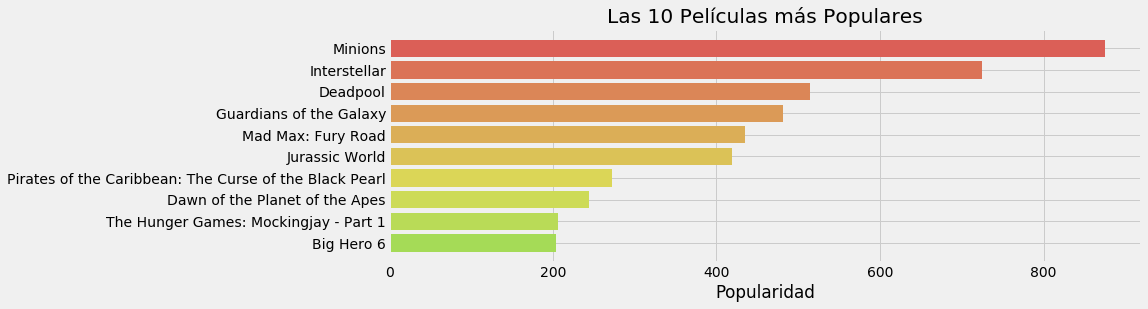

In [128]:
pop= movie.sort_values('popularity', ascending=False)

# Creando plot de 'Las 10 Películas más Populares'
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center',color=sns.color_palette('hls',40))
plt.gca().invert_yaxis()
plt.xlabel("Popularidad")
plt.title("Las 10 Películas más Populares")
plt.show()

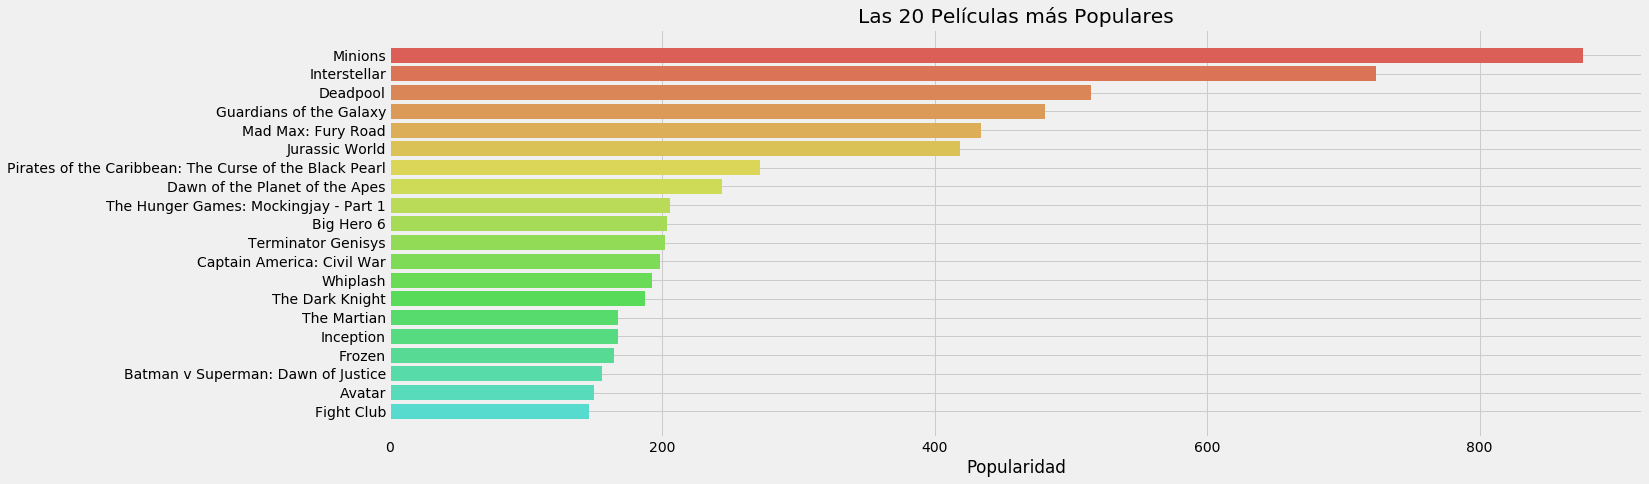

In [129]:
# Se puede incluso no solo hacer un top 10, sino un top 20 para tener mayor información

pop= movie.sort_values('popularity', ascending=False)

# Creando plot de 'Las 10 Películas más Populares'
plt.figure(figsize=(20,7))

plt.barh(pop['title'].head(20),pop['popularity'].head(20), align='center',color=sns.color_palette('hls',40))
plt.gca().invert_yaxis()
plt.xlabel("Popularidad")
plt.title("Las 20 Películas más Populares")
plt.show()

### Análisis Sistema de Recomendación Basado en Filtro Demográfico:

Gracias a este primer sistema de recomendación (bastante sencillo) se puede ver de forma fácil cuáles son las películas "trendy" o que muchas personas han visto y es lo que se muestra de primera entrada en la pestaña descrita. Se puede apreciar como Minios es la película más popular en el sistema que se acaba de construir, de segunda Interstellar, Deadpool y la lista contiúa. 

Sin embargo no hay que olvidar que este sistema de recomendación demográfico provee una idea general de recomendación para todos los usuarios, por lo que, no va a tomar en cuenta los gustos, intereses específicos de los usuarios. 

### Sistema de Recomendación Filtrado Basado en Contenido

En este sistema de recomendación el contenido de la película (*overview*, *cast*, *crew*, *keyword*, *tagline*, etc.) es usado para encontrar similitudes con otras películas, entonces las películas que comparten más similitudes son más probables de ser recomendadas. 

<img src=https://miro.medium.com/max/1334/1*oYpMnPQFZaiZQizgVWBpoA.png>

                                                                        Fuente: imagen tomada de miro.medium.com

#### Recomendador basado en descripción de películas

Se van a calcular puntuaciones de similitud por pares para todas las películas en función de las descripciones de la tramas (*overview*) y se recomendarán películas en función de esa puntuación de similitud. La descripción de la película se proporciona en la función de descripción general del presente dataset.

In [130]:
movie['overview'].head(7)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
5    The seemingly invincible Spider-Man goes up ag...
6    When the kingdom's most wanted-and most charmi...
Name: overview, dtype: object

Como la variable que se necesita tomar está en formato de texto (objeto) es necesario convertir el vector de palabras de cada descripción general (*overview*). Entonces se va a proceder a calcular los vectores de frecuencia de documento inverso de término (Term Frequency-Inverse Document Frequency (TF-IDF)) para cada descripción general (*overview*).

La frecuencia del término, es la frecuencia relativa de una palabra en un documento y se da como (instancias de términos/instancias totales). La frecuencia inversa de documentos es el recuento relativo de documentos que contienen el término y se da como registro (número de documentos/documentos con término). La importancia general de cada palabra para los documentos en los que aparecen es igual a $TF \cdot IDF$

Esto dará como resultado una matriz donde cada columna representa una palabra en el vocabulario general (todas las palabras que aparecen en al menos un documento) y cada fila representa una película, como antes. Esto se hace para reducir la importancia de las palabras que ocurren con frecuencia en las descripciones generales de la trama y, por lo tanto, su importancia en el cálculo de la puntuación final de similitud.

Afortunadamente, scikit-learn brinda una biblioteca llamada:  "TfIdfVectorizer" incorporada que produce la matriz TF-IDF. 

In [131]:
# Importando TfIdfVectorizer de scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Definiendo un TF-IDF objeto vectorizador y removiendo todas las stopwords del inglés como: 'the', 'a', etc.
tfidf = TfidfVectorizer(stop_words='english')

# Reemplazando NaN con strings vacíos
movie['overview'] = movie['overview'].fillna('')

# Construyendo la matriz TF-IDF requerida y transformándola en datos
tfidf_matrix = tfidf.fit_transform(movie['overview'])

# Inspeccionado forma de matriz TF-IDF
tfidf_matrix.shape

(4803, 20978)

Inspeccionando la matriz TF-IDF se puede ver que se están usando casi 20.000 palabras diferentes para describir las 4803 películas del dataset propuesto. 

Con esta matriz ahora se puede calcular una puntuación de similitud. Hay varios candidatos para esto; como las puntuaciones de similitud euclidiana, de Pearson y del coseno. No existe una respuesta correcta para determinar cuál es la mejor puntuación. Diferentes puntuaciones funcionan bien en diferentes escenarios y, a menudo, es una buena idea experimentar con diferentes métricas.

Para este caso específico se utilizará la similitud del coseno para calcular una cantidad numérica que denota la similitud entre dos películas. Se procede a utilizar la puntuación de similitud de coseno ya que es independiente de la magnitud y es relativamente fácil y rápido de calcular por lo que no supondrá mucho poder computacional. Matemáticamente, se define de la siguiente manera:

<img src= https://miro.medium.com/max/1912/1*YObjpgE_1qOTavYe9as-sg.png>

                                                                    Fuente: https://miro.medium.com/
                                                                    

Dado a que se ha utilizado el vectorizador TF-IDF, calcular el producto escalar da como resultado directamente la puntuación de similitud del coseno. Por lo tanto, se usará *linear_kernel* de sklearn en lugar de *cosine_similarities* ya que es más rápido.

In [132]:
# Importando linear_kernel
from sklearn.metrics.pairwise import linear_kernel #sklearn.metrics.pairwise.cosine_similarity(

# Computando la matriz de similitud del coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Se procederá a definir una función que toma el título de una película como entrada y genera una lista de las 10 películas más similares. En primer lugar, para esto, se necesita hacer un mapeo inverso de títulos de películas e índices de DataFrame. En otras palabras, se necesita un mecanismo para identificar el índice de una película en el presente DataFrame de metadatos, dado su título.

In [133]:
#Construyendo un mapeo al revés de índices y títulos de películas
indices = pd.Series(movie.index, index=movie['title']).drop_duplicates()

Hecho lo anterior se puede definir una función de recomendación, por lo que se va a detallar el proceso:

1. Obtener el índice de la película dado su título.
2. Obtener la lista de puntuaciones de similitud de coseno para esa película en particular con todas las películas. 
3. Convertir el output en una lista de tuplas donde el primer elemento es su posición y el segundo es la puntuación de similitud.
4. Ordenar la lista de tuplas antes mencionada en función de las puntuaciones de similitud; es decir, el segundo elemento.
5. Obtener los 10 elementos principales de esta lista. **Importante**: se debe ignorar: el primer elemento, ya que se refiere a sí mismo (la película más similar a una película en particular es la película en sí).
6. Devuelve los títulos correspondientes a los índices de los elementos superiores.

In [134]:
# Función que toma el título de la película como entrada y genera la mayoría de películas similares
def get_recommendations(title, cosine_sim=cosine_sim):
    # Obteniendo el índice de la película que coincide con el título
    idx = indices[title]

    # Obteniendo las puntuaciones de similitud de pares de todas las películas con esa película
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordenando las películas según las puntuaciones de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obteniendo las puntuaciones de las 10 películas más similares
    sim_scores = sim_scores[1:11]

    # Obtendiendo los índices de las películas
    movie_indices = [i[0] for i in sim_scores]

    # Obteniendo el top 10 de películas más similares
    return movie['title'].iloc[movie_indices]

In [135]:
get_recommendations('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title, dtype: object

In [136]:
get_recommendations('The Theory of Everything')

4643                 Like Crazy
1560                 27 Dresses
1996        Someone Like You...
3368         Outside Providence
397            It's Complicated
1891                  Dear John
4119    It's All Gone Pete Tong
2190                      Loser
83                   The Lovers
455           Conspiracy Theory
Name: title, dtype: object

In [137]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

Aunque el sistema he hecho un trabajo relativamente favorable aún la calidad de las recomendaciones no es tan buena, debido a que solo se está buscando por palabras similares. Ya que: "The Avengers" devuelve todas las películas de Avengers, mientras que es más probable que las personas a las que les gustó esa película estén más inclinadas a disfrutar otras películas que no necesariamente sean de la misma trama o del mismo Director, es por ello que se va a proceder a mejorarlo. 

### Recomendación basada en créditos, géneros y palabras clave

La calidad de un recomendador aumentará si este puede tomar más variables en cuenta, por ello es lo que se pretenede hacer en esta sección. Se va a construir un recomendador basado en las siguientes variables: los 3 actores principales, el director, los géneros relacionados (*genres*)y las palabras clave (*Keywords*) de la trama de la película.

Del elenco, el equipo y las características de las palabras clave, se debe extraer los tres actores más importantes, el director y las palabras clave asociadas con esa película. En este momento, los datos están presentes en forma de listas "en cadena", se necesita convertirlos en una estructura segura y utilizable como se hizo en el paso anterior (EDA).

In [138]:
# Uniendo datasets
credit.columns = ['id','tittle','cast','crew'] # Renombrando para unir
movie = movie.merge(credit,on='id')

In [139]:
# Inspeccionando Dataframe
movie.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [140]:
# Asignando las características en cadena en sus correspondientes objetos de Python
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movie[feature] = movie[feature].apply(literal_eval)

In [141]:
# Obteniendo el nombre del director de la película mediante la variable 'crew'. Si el director no figura en la lista, devuelva NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [142]:
# Devuelve los 3 elementos principales de la lista o la lista completa (lo que aparezca primero)
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        # Comprobando si existen más de 3 elementos. En caso afirmativo, devuelva solo los tres primeros. Si no, devuelva la lista completa.
        if len(names) > 3:
            names = names[:3]
        return names

    # Devolviendo una lista vacía en caso de datos faltantes o mal formados
    return []

In [143]:
# Definiendo nuevas características de director, elenco, géneros y palabras clave que estén en una forma adecuada.
movie['director'] = movie['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movie[feature] = movie[feature].apply(get_list)

In [144]:
# Imprimiendo las nuevas variables de los tres primeras películas
movie[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


El siguiente paso sería convertir los nombres y las instancias de palabras clave en minúsculas y eliminar todos los espacios entre ellos. Esto se hace para que el vectorizador no cuente a Johnny de "Johnny Depp" y "Johnny Galecki" como el mismo y lo mismo con diferentes actores que comparten el mismo nombre. 

In [145]:
# Función para convertir todos los strings a lower case y juntar todos los espacios entre palabras
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Comprobando si el director existe, si no, retornando un espacio vacío
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [146]:
# Aplicando una función de limpieza
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movie[feature] = movie[feature].apply(clean_data)

Ahora se pueden unir todas las palabras y se puede explorar para alimentar el vectorizador que se creo anteriormente. 

In [147]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movie['soup'] = movie.apply(create_soup, axis=1)

Los siguientes pasos son los mismos que se hicieron con el recomendador pasado basado en el *overview*. Una diferencia importante es que se va a usar CountVectorizer () en lugar de TF-IDF. Esto se debe a que no se quiere restar importancia a la presencia de un actor/director si ha actuado o dirigido en más películas, ya que no tiene mucho sentido intuitivo.

In [148]:
# Importando CountVectorizer y creando el contador de la matriz
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movie['soup'])

In [149]:
# Computando la matriz de similitud del Coseno matrix basado en el "count_matrix"
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [150]:
# Restableciendo el índice del DataFrame principal y construya el mapeo inverso
movie = movie.reset_index()
indices = pd.Series(movie.index, index=movie['title'])

In [151]:
# Utilizando la función pasada "get_recommendations" y aplicando el coseno_sim2 como segundo argumento

get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [152]:
get_recommendations('Minions', cosine_sim2)

67                                 Monsters vs Aliens
1426                                          Valiant
358                         Atlantis: The Lost Empire
302     Legend of the Guardians: The Owls of Ga'Hoole
2464                           The Master of Disguise
294                                              Epic
418       Cats & Dogs 2 : The Revenge of Kitty Galore
479                            Walking With Dinosaurs
1620                                  Winnie the Pooh
2823        Harold & Kumar Escape from Guantanamo Bay
Name: title, dtype: object

In [153]:
get_recommendations('Life of Pi', cosine_sim2)

2515    Crouching Tiger, Hidden Dragon
4638          Amidst the Devil's Wings
678                       Dragon Blade
3087                 Nicholas Nickleby
4143                          Rockaway
1273                       Extreme Ops
1667                        Supercross
2205                        Undisputed
2474           Arn: The Knight Templar
2708                          Caravans
Name: title, dtype: object

In [154]:
get_recommendations('Seven Pounds', cosine_sim2)

824     The Pursuit of Happyness
264                          Ali
1424                  Concussion
3415        Remember Me, My Love
4217                        Kids
4564    Straight Out of Brooklyn
1235                        Rent
3043            End of the Spear
396           Enemy of the State
815                        Hitch
Name: title, dtype: object

In [155]:
get_recommendations('Juno', cosine_sim2)

4247       Me You and Five Bucks
1026    Riding in Cars with Boys
2301        Take Me Home Tonight
2356             Youth in Revolt
2718                    Clueless
3368          Outside Providence
4532                Lonesome Jim
3989        Lage Raho Munna Bhai
4687                   Good Dick
323           Sex and the City 2
Name: title, dtype: object

### Análisis del Sistema de Recomendación Filtrado Basado en Contenido

Se puede ver que este recomendador ha tenido éxito en capturar más información debido a más datos de entrada (mayor cantidad de parámetros) y ha dado (posiblemente) mejores recomendaciones. Es más probable que a los fanáticos de Disney les gusten las películas de la misma casa de producción o que a los fanáticos de películas independientes les agrade saber alguna otra película creada por directores que comparten gustos similares; por lo tanto, a las características anteriores se les puede agregar production_company. También se puede aumentar el peso del director, agregando la función varias veces en la 'soup'.

### Sistema de Recomendación basado en Filtración colaborativa

El sistema de recomendación creado hasta ahora (el más robusto) padece de graves limitaciones, debido a que solo es capaz de sugerir películas cercanas a una determinada película. Es decir, no es capaz de captar gustos y ofrecer recomendaciones de todos los géneros a los diferentes usuarios que quieran ver una película o determinados géneros como se tiene hoy en día en los recomendadores más famosos. 

Además, el motor que se construyó no es realmente personal, ya que no captura los gustos y prejuicios personales de un usuario. Cualquiera que consulte este motor para obtener recomendaciones basadas en una película recibirá las mismas recomendaciones para esa película, independientemente de quién sea, lo que sí sucede con los que tienen Netflix o Disney+. 

Por lo tanto, en esta sección, se usará un algoritmo llamada Filtrado colaborativo para hacer recomendaciones a los espectadores de películas. 

Es básicamente de dos tipos:

* Filtrado basado en el usuario: estos sistemas recomiendan productos a un usuario y que le han gustado a usuarios similares. Para medir la similitud entre dos usuarios, se puede usar la correlación de Pearson o la similitud del coseno. 

* Filtrado colaborativo basado en elementos: en lugar de medir la similitud entre usuarios, el Filtrado colaborativo basado en elementos recomienda elementos en función de su similitud con los elementos que calificó el usuario objetivo. Asimismo, la similitud se puede calcular con la correlación de Pearson o la similitud de coseno. La principal diferencia es que, con el filtrado colaborativo basado en elementos, se llena el espacio en blanco verticalmente, en oposición a la forma horizontal que lo hace el Filtrado colaborativo basado en el usuario.

Con lo anterior se evita con éxito el problema que plantea la preferencia dinámica del usuario, ya que el Filtrado Colaborativo (de ahora en adelante FC) basado en elementos es más estático. Sin embargo, persisten varios problemas para este método. 

**El problema principal es la escalabilidad:** el cálculo crece tanto con el cliente como con el producto. La complejidad del peor caso es O (mn) con m usuarios y n elementos. Además, la escasez es otra preocupación. En casos extremos, se puede tener millones de usuarios y la similitud entre dos películas bastante diferentes podría ser muy alta simplemente porque tienen un rango similar para el único usuario que los clasificó a ambos.

#### Descomposición de valor único

Una forma de manejar el problema de escalabilidad y escasez creado por el FC es aprovechar un modelo de factor latente para capturar la similitud entre usuarios y elementos. Esencialmente, se quiere convertir el problema de recomendación en un problema de optimización. Se puede ver como "lo buenos que somos al predecir la calificación de los elementos asignados a un usuario". Una métrica común es el error cuadrático medio (RMSE). Cuanto menor sea el RMSE, mejor será el rendimiento.

Ahora, hablando de factor latente, es posible que se pregunte qué es, y es una idea amplia que describe una propiedad o concepto que tiene un usuario o un elemento. Por ejemplo, para las películas, el factor latente puede referirse al género al que pertenece la película. La Descomposición de valor único disminuye la dimensión de la matriz de utilidad al extraer sus factores latentes. Esencialmente, se mapea a cada usuario y cada elemento en un espacio latente con dimensión $R$. Por lo tanto, ayuda a comprender mejor la relación entre los usuarios y los elementos a medida que se vuelven directamente comparables. 

La siguiente figura ilustra esta idea: 

<img src= https://www.statdeveloper.com/wp-content/uploads/2020/03/colaborativo-3.png>

                                                                    Fuente: https://www.statdeveloper.com

Dado que el dataset que se ha estado usando no cuenta con userId (que es necesario para el filtrado colaborativo), se va a cargar otro dataset.

In [156]:
pip install surprise

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [157]:
# Importando dataset de scores por usuario
bucket='imdbuser'
data_key = 'mdbuser/ratings_small.csv'
data_location = 's3://imdbuser/ratings_small.csv'.format(bucket, data_key)

users = pd.read_csv(data_location)

In [158]:
import random                                                              
from surprise import reader
from surprise import SVD                                                   
from surprise import Dataset                                               
from surprise import accuracy                                              
from surprise.model_selection import GridSearchCV

In [159]:
# Importando nuevo dataset
users.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


**Importante #1:** para este dataset no se ve necesario hacer un EDA, ya que forma parte del algoritmo de optimización. 

**Importante #2:** Tenga en cuenta que en este conjunto de datos, las películas se clasifican en una escala de 5 a diferencia de la anterior y recuerde que lo que se está tratando de hacer a partir de ahora es predecir "qué tan buenos somos recomendado una película a un usuario" basado en todos los "ratings" de las personas que la vieron o puedan ver con base el conjunto de datos totales. 

In [160]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Definiendo parámetros de timstamp separator
reader = Reader(line_format='user item rating timestamp', sep='\t')

# Definiendo dataset
data = Dataset.load_from_df(users[['userId', 'movieId', 'rating']], reader = reader)  

# Creando evaluación del modelo
cross_validate(BaselineOnly(), data, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8849  0.9001  0.8925  0.8866  0.9034  0.8935  0.0073  
MAE (testset)     0.6835  0.6951  0.6917  0.6861  0.6958  0.6905  0.0049  
Fit time          0.16    0.18    0.21    0.18    0.22    0.19    0.02    
Test time         0.11    0.11    0.24    0.11    0.11    0.13    0.05    


{'test_rmse': array([0.88485256, 0.90010369, 0.89253525, 0.88661998, 0.90336176]),
 'test_mae': array([0.6835    , 0.69510545, 0.69174806, 0.68612925, 0.69577012]),
 'fit_time': (0.164076566696167,
  0.18426227569580078,
  0.21068930625915527,
  0.18259525299072266,
  0.2249314785003662),
 'test_time': (0.1080315113067627,
  0.10873174667358398,
  0.23941636085510254,
  0.10605835914611816,
  0.10932302474975586)}

Se obtiene un RMSE de 0.89 aproximadamente, lo que es bastante bueno porque es bastante bajo. 

In [161]:
# Importando parámetros de evalución
from surprise import Reader, Dataset, SVD

In [162]:
# Renombrando función
svd = SVD()

In [163]:
# Entrenando modelo
trainset = data.build_full_trainset()
svd.fit(trainset)

In [164]:
# Escogiendo al usuario con Id=1 y verificando las calificaciones que ha dado
users[users['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [165]:
svd.predict(1, 3777, 4)

Prediction(uid=1, iid=3777, r_ui=4, est=2.5359163715210036, details={'was_impossible': False})

In [166]:
svd.predict(924, 1345, 2)

Prediction(uid=924, iid=1345, r_ui=2, est=3.671180979640961, details={'was_impossible': False})

### Sistema de Recomendación basado en Filtración colaborativa

Para la película con movieId= 3777, se obtiene una predicción estimada de 2.53, es decir, si la película mencionada se le recomienda al UserId = 1, es probable que este le guste en un 50%. Recordar que este score se basa en puntuaciones de 1 a 5. 

En cambio para el usuario número 924, la película número 1345 si se le recomienda de una puntuación de 3.67, es decir la película tiene más de un 70% de posibilidades de que le guste a este usuario. 

Una característica sorprendente de este sistema de recomendación es que no le importa qué película es (o qué contiene). Funciona únicamente sobre la base de una ID de película asignada e intenta predecir las calificaciones en función de cómo los otros usuarios han predicho la película.